In [2]:
import sys, os, pickle
from joblib import Parallel, delayed
import pandas as pd
from jumpmodels.utils import filter_date_range
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from jumpmodels.sparse_jump import SparseJumpModel
from sklearn.preprocessing import StandardScaler
from pypfopt.black_litterman import BlackLittermanModel, market_implied_prior_returns
from pypfopt.efficient_frontier import EfficientFrontier
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import exceptions 
from scipy.optimize import brentq
import cvxpy as cp
from scipy import stats

sys.path.append('/Users/victor/Documents/thesis_vri_vp/vic_new')         # for mac
#sys.path.append('C:\\Users\\victo\\git_new\\thesis_vri_vp\\vic_new')      # for windows
from feature_set_v2 import MergedDataLoader 

In [3]:
# 0) Global parameters ------------------------------------------------------------------
REFIT_FREQ        = "ME"        
MIN_TRAINING_YEARS= 8
MAX_TRAINING_YEARS= 12
INITIAL_TRAIN_START = "2002-05-31"
test_start        = "2017-02-01"

# Paths & tickers -----------------------------------------------------------------------
script_dir = os.getcwd()
base_dir   = os.path.abspath(os.path.join(script_dir, "..", "..", "..", ".."))
data_dir   = os.path.join(base_dir, "data_new")

factor_file = os.path.join(data_dir, "1estimation_index_returns.csv")
market_file = os.path.join(data_dir, "1macro_data.csv")
etf_file    = os.path.join(data_dir, "2trading_etf_returns_aligned.csv")

factors = ["iwf", "mtum", "qual", "size", "usmv", "vlue"]   # used everywhere


In [4]:
# ──────────────────────────────────────────────────────────────
# DATA‑LOADING BLOCK  (pulled from old notebook)
# ──────────────────────────────────────────────────────────────

# 1) Load full data for every factor + market ------------------------------------------------
factor_data_dict  = {}
factor_returns_ls = []

for fac in factors:
    print(f"Loading data for {fac}")
    data = MergedDataLoader(
        factor_file=factor_file,
        market_file=market_file,
        ver="v2",
        factor_col=fac
    ).load()

    common_idx = (data.X.index
                  .intersection(data.ret_ser.index)
                  .intersection(data.market_ser.index))

    X_full        = data.X.loc[common_idx]
    fac_ret_full  = data.ret_ser.loc[common_idx]
    mkt_ret_full  = data.market_ser.loc[common_idx]
    active_ret    = fac_ret_full - mkt_ret_full

    factor_data_dict[fac] = {
        "X"        : X_full,
        "fac_ret"  : fac_ret_full,
        "mkt_ret"  : mkt_ret_full,
        "active_ret": active_ret,
    }
    factor_returns_ls.append(fac_ret_full)

# save last loop’s mkt_ret_full as market series
all_market_ret = mkt_ret_full

# 2) Assemble master return dataframe (factors + Market + rf) -------------------------------
full_factors_df = pd.concat(factor_returns_ls, axis=1).dropna()
full_df = pd.concat([full_factors_df, all_market_ret], axis=1).dropna()
full_df.columns = factors + ["Market"]

# risk‑free
etf_df   = pd.read_csv(etf_file, index_col=0, parse_dates=True).dropna().sort_index()
rf_ser   = etf_df["rf"]
full_df  = pd.concat([full_df, rf_ser], axis=1).dropna()
full_df.columns = factors + ["Market", "rf"]

# 3) Define test index (everything from 2017‑01‑01 on) --------------------------------------
test_slice = full_df.loc[test_start:]
test_index = test_slice.index.sort_values()
# ──────────────────────────────────────────────────────────────


Loading data for iwf
Loading data for mtum
Loading data for qual
Loading data for size
Loading data for usmv
Loading data for vlue


In [5]:
# ------------------------------------------------------------
# 1  BUILD & CACHE FACTOR‑VIEWS  (run once, takes minutes)
# ------------------------------------------------------------
VIEWS_FILE = "lam50factor_views.pkl" # "SAVEfactor_views.pkl" is the views for the outperforming sharpe run
FORCE_REBUILD = False 

def _fit_one_factor(fac, refit_date, test_dates_chunk,
                    factor_data_dict, hyperparams,
                    min_years, max_years, init_start):

    # ---------- helpers ----------
    def get_train_window(current_date, full_data):
        train_end  = current_date
        train_start= max(train_end - pd.DateOffset(years=max_years),
                         pd.to_datetime(init_start))
        if (train_end - train_start) < pd.Timedelta(days=365.25*min_years):
            train_start = train_end - pd.DateOffset(years=min_years)
        idx = full_data.index
        subset = idx[(idx >= train_start) & (idx <= train_end)]
        start_date, end_date = subset.min(), subset.max()
        return start_date, end_date 

    # ---------- data ----------
    fac_data = factor_data_dict[fac]
    X   = fac_data["X"]
    ret = fac_data["fac_ret"]
    act = fac_data["active_ret"]

    lam = hyperparams["new_lambda"]
    kp  = hyperparams["new_kappa"]
    train_start, train_end = get_train_window(refit_date, X)

    # ---------- preprocess ----------
    clipper = DataClipperStd(mul=3.0)
    scaler  = StandardScaler()
    X_train = scaler.fit_transform(clipper.fit_transform(
                 filter_date_range(X, train_start, train_end)))
    active_train = filter_date_range(act, train_start, train_end)

    # ---------- fit SJM ----------
    sjm = SparseJumpModel(n_components=2,
                          max_feats=int(kp**2),
                          jump_penalty=lam)
    
    train_idx = filter_date_range(X, train_start, train_end).index
    X_train_df = pd.DataFrame(X_train, index=train_idx, columns=X.columns)
    sjm.fit(X_train_df, ret_ser=active_train, sort_by="cumret")

    ret_train = filter_date_range(ret, train_start, train_end)

    # regime‑level abs returns
    train_states = sjm.predict(X_train_df)
    abs_ret = {}
    for st in range(2):
        st_idx = (train_states==st)
        abs_ret[st] = ret_train.loc[st_idx].mean() * 252

    # ---------- online prediction for test dates ----------
    states = {}
    for day in test_dates_chunk:
        X_hist = X.loc[:day]                          # all history up to 'day'
        temp_clipper = DataClipperStd(mul=3.0)
        X_hist_clip  = temp_clipper.fit_transform(X_hist)

        temp_scaler  = StandardScaler()
        _ = temp_scaler.fit_transform(X_hist_clip)    # fit on *all* history

        if day in X.index:
            X_day_clip   = temp_clipper.transform(X.loc[[day]])
            X_day_scaled = temp_scaler.transform(X_day_clip)
            states[day]  = sjm.predict_online(
                pd.DataFrame(X_day_scaled,
                            index=[day],
                            columns=X.columns)).iloc[0]

    # assemble mini‑df for this factor & period
    out = pd.DataFrame({"state": pd.Series(states)},
                       index=list(states.keys()))
    out["ann_abs_ret"] = out["state"].map(abs_ret)
    return fac, out

def build_factor_views(factor_data_dict, saved_hyperparams, factors,
                       test_index,
                       refit_freq="ME", min_years=8, max_years=12,
                       init_start="2002-05-31"):

    views = {f:[] for f in factors}
    refit_dates = (test_index.to_series()
                   .resample(refit_freq)
                   .last()
                   .dropna())

    for j, refit_date in enumerate(refit_dates):
        if j < len(refit_dates)-1:
            next_refit = refit_dates.iloc[j+1]
        else:
            next_refit = test_index[-1]
        test_mask = (test_index>refit_date)&(test_index<=next_refit)
        test_chunk = test_index[test_mask]

        # ---- parallel over factors ----
        jobs = []
        for fac in factors:
            # latest hyperparams before refit_date
            hp_hist = [h for h in saved_hyperparams[fac]
                       if pd.to_datetime(h["date"])<=refit_date]
            if not hp_hist: continue
            hp = hp_hist[-1]
            jobs.append(delayed(_fit_one_factor)(
                fac, refit_date, test_chunk,
                factor_data_dict, hp,
                min_years, max_years, init_start))
        for fac, df in Parallel(n_jobs=-1)(jobs):
            views[fac].append(df)

    # concat & tidy
    for fac in factors:
        views[fac] = (pd.concat(views[fac])
                      .sort_index()
                      .loc[:,["state","ann_abs_ret"]])
    return views


# --------- build or load ----------         
if FORCE_REBUILD or not os.path.exists(VIEWS_FILE):
    factor_views = build_factor_views(factor_data_dict, saved_hyperparams, factors, 
                                      test_index,
                                      refit_freq=REFIT_FREQ, 
                                      min_years=8, max_years=12, init_start="2002-05-31")
    with open(VIEWS_FILE, "wb") as f:
        pickle.dump(factor_views, f)
else:
    with open(VIEWS_FILE, "rb") as f:
        factor_views = pickle.load(f)



In [6]:
# ------------------------------------------------------------
# 2  FAST BLACK‑LITTERMAN FUNCTION  (run as often as you like)
# ------------------------------------------------------------

def ewm_covariance(returns, halflife=126, min_periods=60):
    ewm_cov = returns.ewm(halflife=halflife,
                          adjust=False,
                          min_periods=min_periods).cov()
    if returns.empty: return pd.DataFrame()
    return ewm_cov.loc[returns.index[-1]]

def detect_state_shifts(views, factors):
    # 1 col per factor with the model‑state
    state_df = pd.concat({f: views[f]["state"] for f in factors}, axis=1)
    # True when *any* factor changes state vs. the day before
    return state_df.ne(state_df.shift()).any(axis=1)

def bl_max_sharpe_te(cov_hist, pi, views, tau, delta,
                     w_bmk, te_target, bounds, rf,
                     use_bl_cov=False):

    bl = BlackLittermanModel(cov_hist, pi=pi, tau=tau,
                             delta=delta, absolute_views=views)

    # pick the risk matrix
    Sigma = bl.bl_cov().values if use_bl_cov else cov_hist.values
    mu    = bl.bl_returns().values
    n     = len(mu)

    w = cp.Variable(n)
    w_act = w - w_bmk.values

    prob = cp.Problem(
        cp.Maximize((mu - rf) @ w),
        [
            cp.sum(w) == 1,
            w >= np.array([lo for lo, hi in bounds]),
            w <= np.array([hi for lo, hi in bounds]),
            cp.quad_form(w_act, Sigma) <= (te_target/np.sqrt(252))**2
        ]
    )
    prob.solve(solver="SCS")
    return pd.Series(w.value, index=w_bmk.index)


def run_bl_once(views, returns_df, full_df,
                shift_series=None,
                tau=0.05, delta=2.5,
                te_target=0.05, # 5 % TE
                trade_market=True,
                use_bl_cov=False,
                allow_market_short=False,
                allow_factor_short=False,
                use_bl_prior=False,     
                fallback_strategy="HOLD_RFR", # "HOLD_RFR", "SHORT_MARKET"
                tcost=0.0005):

    assets  = returns_df.columns.tolist()
    factors = list(views.keys())
    if trade_market:
        trade_assets = [a for a in returns_df.columns if a != "rf"]
    else:
        trade_assets = [a for a in returns_df.columns
                        if a not in {"rf", "Market"}]
    cash_asset = "rf"

    market_caps = {etf: 1.0 for etf in trade_assets}

    # ---------- per‑asset bounds ----------
    bounds = []
    for a in trade_assets:
        if a == "Market":
            bounds.append((-1, 1) if allow_market_short else (0, 1))
        else:
            bounds.append((-1, 1) if allow_factor_short else (0, 1))

    w = pd.DataFrame(index=returns_df.index,
                     columns=trade_assets + [cash_asset], # was + [cash_asset]
                     dtype=float)

    for t in returns_df.index:
        # ------ carry weights forward if no trade today ------
        if shift_series is not None and not shift_series.loc[t]:
                w.loc[t] = w.shift(1).loc[t] 
                continue
        
        # ------ optimiser block ------
        hist  = full_df[trade_assets].loc[:t].iloc[:-1]
        cov   = ewm_covariance(hist) * 252
        if cov.empty or cov.isna().any().any():
            continue

        if use_bl_prior:
            prior_for_bl = market_implied_prior_returns(market_caps, delta, cov)
        else:
            prior_for_bl = "equal"          # or None

        rf_annual = returns_df.loc[t, cash_asset] * 252

        VIEW_SCALE = 5 
        q = {fac: (views[fac].loc[t, "ann_abs_ret"] - rf_annual) * VIEW_SCALE for fac in factors} 

        
        # ----- ***lightweight BL*** just for the fallback test ------------
        bl0 = BlackLittermanModel(cov, pi=prior_for_bl,
                                tau=tau, delta=delta,
                                absolute_views=q)

        # ===== fallback: all ERs ≤ cash ===================================
        if (bl0.bl_returns() <= rf_annual).all():
            w.loc[t] = 0.0
            if fallback_strategy == "HOLD_RFR":
                w.loc[t, cash_asset] = 1.0
            elif (fallback_strategy == "SHORT_MARKET"
                and "Market" in trade_assets):
                w.loc[t, "Market"] = -1.0
                w.loc[t, cash_asset] = 1.0
            continue               # ← next date
        # =================================================================

        # ---- target-TE BL optimisation --------------------------------
        w_bmk = pd.Series(1/len(trade_assets), index=trade_assets)

        w_t = bl_max_sharpe_te(cov,
                            pi=prior_for_bl,
                            views=q,
                            tau=tau, delta=delta,
                            w_bmk=w_bmk,
                            te_target=te_target,          # 5 % TE
                            bounds=bounds,
                            rf=rf_annual,
                            use_bl_cov=use_bl_cov)
        w.loc[t, trade_assets] = w_t

    # ---------- P&L ----------
    pnl = (w.shift(1).fillna(0) * returns_df).sum(axis=1)
    if tcost > 0:
        pnl -= w.diff().abs().sum(axis=1).fillna(0) * tcost

    return w, pnl


In [ ]:
# ------------------------------------------------------------
# 3  QUICK EXPERIMENTS
# ------------------------------------------------------------
def annualized_sharpe(r):          # helper
    return (r.mean() / r.std()) * np.sqrt(252)

def ann_turnover(w):
    daily_turn = w.diff().abs().sum(axis=1).mean()
    return daily_turn * 252

test_df = full_df.loc[test_index]
shift_days = detect_state_shifts(factor_views, factors).reindex(test_df.index, fill_value=False)
shift_days.iloc[0] = True

cfgs = [
    # these are the standard BL cov and BL prior that got 94 SR - now just trying different TE
     dict(label="94 SR + BL cov + BL prior - 5% TE",  tau=0.05, delta=2.5, shift_series=None, trade_market=True,
         use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.05),
    #  dict(label="94 SR + BL cov + BL prior - 4% TE",  tau=0.05, delta=2.5, shift_series=None,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.04),
     dict(label="94 SR + BL cov + BL prior - 3% TE",  tau=0.05, delta=2.5, shift_series=None, trade_market=True,
         use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.03),
     dict(label="94 SR + BL cov + BL prior - 2% TE",  tau=0.05, delta=2.5, shift_series=None, trade_market=True,
         use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.15),     
     dict(label="94 SR + BL cov + BL prior - 1% TE",  tau=0.05, delta=2.5, shift_series=None, trade_market=True,
         use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.01),

    # standard BL cov and BL prior trading only on shifts
     dict(label="Only on shifts - 5% TE",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
         use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.05),
    #  dict(label="Only on shifts - 4% TE",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.04),
     dict(label="Only on shifts - 3% TE",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
         use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.03),
     dict(label="Only on shifts - 15% TE",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
         use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.15),     
     dict(label="Only on shifts - 1% TE",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
         use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.01),
  

    #  # standard BL cov and BL prior that got 94 SR - now allowing shorts
    #  dict(label="94 SR + BL cov + BL prior - L/S mkt and fac",  tau=0.05, delta=2.5,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.03),
    #  dict(label="94 SR + BL cov + BL prior - L/S mkt L fac",  tau=0.05, delta=2.5,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=True, allow_factor_short=False, te_target=0.03),


    #  # standard set ups from 94SR run - now falling back on market short
     dict(label="94 SR + BL cov + BL prior - fallback mkt short",  tau=0.05, delta=2.5, shift_series=shift_days,
         use_bl_cov=True, use_bl_prior=True, allow_market_short=True, allow_factor_short=False, te_target=0.03,
         fallback_strategy="SHORT_MARKET"),
     dict(label="Long only base without daily trade",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=False,
         use_bl_cov=False, use_bl_prior=False, allow_market_short=False, allow_factor_short=False, te_target=0.02),
     dict(label="Long only base with daily trade",  tau=0.05, delta=2.5,shift_series=None, trade_market=False,
         use_bl_cov=False, use_bl_prior=False, allow_market_short=False, allow_factor_short=False, te_target=0.02),
     dict(label="+BL cov -BL prior - without daily trade",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=False,
         use_bl_cov=True, use_bl_prior=False, allow_market_short=False, allow_factor_short=False, te_target=0.02),
     dict(label="+BL cov -BL prior - with daily trade",  tau=0.05, delta=2.5,shift_series=None, trade_market=False,
         use_bl_cov=True, use_bl_prior=False, allow_market_short=False, allow_factor_short=False, te_target=0.02),
     dict(label="-BL cov +BL prior - without daily trade",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=False,
         use_bl_cov=True, use_bl_prior=False, allow_market_short=False, allow_factor_short=False, te_target=0.02),
     dict(label="-BL cov +BL prior - with daily trade",  tau=0.05, delta=2.5,shift_series=None, trade_market=False,
         use_bl_cov=True, use_bl_prior=False, allow_market_short=False, allow_factor_short=False, te_target=0.02),
]


run_results = {}                   # label → dict(rets, wts, cfg)
for c in cfgs:
    label = c.pop("label")         # remove label before **c
    wts, rets = run_bl_once(factor_views, test_df, full_df, **c)  # set shift_series to None to trade daily. set to shift_days to only trade on regime shifts
    run_results[label] = dict(returns=rets, weights=wts, cfg=c)
    #print(f"{label:12s}  Sharpe {annualized_sharpe(rets):6.3f}")

print()

rows = []
for label, res in run_results.items():
    rows.append({
        "Strategy": label,
        "Sharpe": annualized_sharpe(res["returns"]),
        "Turnover": ann_turnover(res["weights"])
    })

# make and print the table
df_table   = pd.DataFrame(rows)
print(df_table.to_string(index=False,float_format=lambda x: f"{x:.3f}"))






               Strategy  Sharpe  Turnover
Only on shifts - 15% TE   0.494    15.978


In [8]:
# These results are from 5% TE with the historical crossvals

# build a list of dicts from your run_results
rows = []
for label, res in run_results.items():
    rows.append({
        "Strategy": label,
        "Sharpe": annualized_sharpe(res["returns"]),
        "Turnover": ann_turnover(res["weights"])
    })

# make and print the table
df_table   = pd.DataFrame(rows)
print(df_table.to_string(index=False,float_format=lambda x: f"{x:.3f}"))

               Strategy  Sharpe  Turnover
Only on shifts - 15% TE   0.494    15.978


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import SelectMultiple, Dropdown, ToggleButtons, VBox, HBox, interact

# If you rely on the package implementation instead of your own definition,
# uncomment the next line:
from jumpmodels.plot import plot_cumret

# 0) remove any old EW entries
for k in list(run_results):
    if k.startswith("Quarterly EW"):
        run_results.pop(k)

# 1) compute quarterly EW over ONLY the risky assets (no rf, no Market)
TCOST = 0.0005
df    = etf_df.loc[test_index.intersection(etf_df.index)].drop(columns=["rf","Market"])
n     = df.shape[1]

# quarter-end dates
first = df.index[0]
qends = (df.index.to_series()
           .resample("QE").last()
           .dropna()
           .index)
if first not in qends:
    qends = qends.insert(0, first)

ew_rets    = pd.Series(index=df.index, dtype=float)
ew_weights = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)
prev_w     = np.zeros(n)

for i in range(len(qends)-1):
    start, end = qends[i], qends[i+1]
    period      = df.loc[(df.index>start) & (df.index<=end)]
    w           = np.ones(n) / n
    for j, day in enumerate(period.index):
        ew_weights.loc[day] = w
        r_i  = period.loc[day].values
        tc   = TCOST * np.abs(w - prev_w).sum() if j == 0 else 0.0
        p    = w.dot(r_i) - tc
        ew_rets.loc[day] = p
        w    = w * (1 + r_i)
        if (1 + p) != 0:
            w /= (1 + p)
    prev_w = w.copy()

ew_rets = ew_rets.dropna()
ew_cum  = ew_rets.cumsum()

# 2) build active-dates mask and trim weights
active = pd.Index([])
for cfg in run_results.values():
    idx = cfg["weights"].drop(columns=["rf","Market"], errors="ignore") \
                        .dropna(how="all").index
    active = active.union(idx)
active = active.sort_values()

ew_w = ew_weights.loc[ew_weights.index.isin(active)]

# inject the single EW portfolio
run_results["Quarterly EW (no rf, no mkt, 5bps)"] = {
    "returns": ew_rets,
    "weights": ew_w
}

# 3) widgets
labels = list(run_results)
cmp    = SelectMultiple(options=labels,
                        value=tuple(labels[:2]),
                        description="Compare:",
                        rows=min(8, len(labels)),
                        style={"description_width": "70px"})
wgt    = Dropdown(options=labels,
                  value=labels[0],
                  description="Weights:",
                  style={"description_width": "70px"})
sign   = ToggleButtons(options=[("Both", "both"),
                                ("Positive", "pos"),
                                ("Negative", "neg")],
                       value="both",
                       description="Show:",
                       style={"description_width": "70px"})

def ann_return(returns):
    """Annualised return: (total cumulative growth)^(252/N) - 1"""
    total_ret = (1 + returns).prod()
    n = returns.shape[0]
    return total_ret**(252 / n) - 1

def ann_volatility(returns):
    """Annualised vol: σ * √252"""
    return returns.std() * np.sqrt(252)

def sharpe(x):
    return x.mean() / x.std() * np.sqrt(252)

def max_drawdown(returns):
    cum = (1 + returns).cumprod()
    peak = cum.cummax()
    dd = (cum / peak - 1)
    return -dd.min()

def total_turnover(weights):
    w = weights.ffill().fillna(0)
    return w.diff().abs().sum().sum()

def sortino(returns, mar=0.0):
    downside = returns[returns < mar]
    dd_std = downside.std()
    return returns.mean() / dd_std * np.sqrt(252) if dd_std > 0 else np.nan

def calmar(returns):
    total_ret = (1 + returns).prod()
    n = len(returns)
    ann_ret = total_ret**(252 / n) - 1
    mdd = max_drawdown(returns)
    return ann_ret / mdd if mdd > 0 else np.nan

def information_ratio(pnl, bench):
    a, b = pnl.align(bench, join="inner")
    active = a - b
    return active.mean() / active.std() * np.sqrt(252)

def hit_rate_long_vs_short(factor_views, factor_returns, look_ahead=21):
    hits, total = 0, 0
    for fac, v in factor_views.items():
        states = v["state"].dropna().astype(int)
        r      = factor_returns[fac]
        for t, st in states.items():
            if t not in r.index:
                continue
            fwd = (r.shift(-1)
                     .loc[t:t + pd.offsets.BDay(look_ahead)]
                     .mean())
            if pd.isna(fwd):
                continue
            exp_sign = 1 if st == 0 else -1   # 0 = bull, 1 = bear
            if np.sign(fwd) == exp_sign:
                hits += 1
            total += 1
    return hits / total if total else np.nan

def _update(compare, weights_cfg, sign_filter):
    if not compare:
        print("Pick ≥1 config.")
        return

    # --------- cumulative returns (now via jumpmodels.plot_cumret) ---------
    data = {"Quarterly EW (no rf, 5bps)": ew_rets}
    for lab in compare:
        data[lab] = run_results[lab]["returns"]
    ret_df = pd.DataFrame(data)
    plot_cumret(ret_df)                 # << replacement
    plt.title("Cumulative Returns")
    plt.grid()
    plt.legend()
    plt.show()
    # ----------------------------------------------------------------------

    # Sharpe table
    print("Annualised Sharpe ratios")
    print(f"  EW            : {sharpe(ew_rets):.3f}")
    for lab in compare:
        print(f"  {lab:<12s}: {sharpe(run_results[lab]['returns']):.3f}")

    # weights over time
    wdf = run_results[weights_cfg]["weights"].dropna(how="all")
    if sign_filter == "pos":
        wdf = wdf.where(wdf > 0, 0)
    elif sign_filter == "neg":
        wdf = wdf.where(wdf < 0, 0)

    plt.figure(figsize=(12, 6))
    plt.stackplot(wdf.index, wdf.T.values, labels=wdf.columns)
    filt = {"both": "(all)", "pos": "(positive)", "neg": "(negative)"}[sign_filter]
    plt.title(f"Weights over time – {weights_cfg} {filt}")
    plt.xlabel("Trading days")
    plt.ylabel("Weight")
    plt.legend(loc="center left", bbox_to_anchor=(1, .5), fontsize="small")
    plt.tight_layout()
    plt.show()

ui = VBox([HBox([cmp, wgt, sign])])
interact(_update, compare=cmp, weights_cfg=wgt, sign_filter=sign)

# 4) realised TE + summary
def te(pnl, bench):
    a, b = pnl.align(bench, join="inner")
    return np.sqrt(252) * (a - b).std()

rows = []
for lab, res in run_results.items():
    r, w = res["returns"], res["weights"]
    rows.append({
        "Strategy"       : lab,
        "Ann. Return"    : ann_return(r),
        "Ann. Volatility": ann_volatility(r),
        "Sharpe"         : sharpe(r),
        "Info Ratio"     : information_ratio(r, ew_rets),
        "Turnover"       : ann_turnover(w),
        "Total Turnover" : total_turnover(w),
        "Realised TE"    : te(r, ew_rets),
        "Max Drawdown"   : max_drawdown(r),
        "Sortino"        : sortino(r),
        "Calmar"         : calmar(r)
    })

df = pd.DataFrame(rows)
print(df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

look_ahead = 21  # days you care about
overall_hit = hit_rate_long_vs_short(
    factor_views,
    {f: factor_data_dict[f]["active_ret"] for f in factors},
    look_ahead=look_ahead
)
print(f"Model hit-rate (bull→pos, bear→neg, next {look_ahead} bdays): "
      f"{overall_hit:.1%}")


interactive(children=(SelectMultiple(description='Compare:', index=(0, 1), options=('Only on shifts - 15% TE',…

                          Strategy  Ann. Return  Ann. Volatility  Sharpe  Info Ratio  Turnover  Total Turnover  Realised TE  Max Drawdown  Sortino  Calmar
           Only on shifts - 15% TE        0.049            0.110   0.494      -0.419    15.978         131.357        0.143         0.299    0.524   0.165
Quarterly EW (no rf, no mkt, 5bps)        0.102            0.184   0.619         NaN     0.825           7.732        0.000         0.350    0.737   0.291
Model hit-rate (bull→pos, bear→neg, next 21 bdays): 51.2%


In [10]:
# 5) Spearman correlation of factor views with next month’s active return.
# Those correlations are basically zero—your state-based view has no measurable relationship with next-month returns.
for f in factors:
    mu = factor_views[f]['ann_abs_ret']   # view
    r  = factor_data_dict[f]["active_ret"].shift(-21)    # next-month
    print(f, mu.corr(r, method='spearman'))

iwf -0.013967016001119287
mtum 0.00897627294867217
qual 0.002236468288685645
size -0.005354230720971561
usmv 0.013866594495038303
vlue 0.02209700025395175


In [11]:
# 5) Sharpe comparison tests vs EW
def sharpe_z_test(pnl, bench, periods=252):
    idx = pnl.index.intersection(bench.index)
    x, y = pnl.loc[idx], bench.loc[idx]
    n    = len(x)
    sr_p = x.mean()/x.std(ddof=1)*np.sqrt(periods)
    sr_b = y.mean()/y.std(ddof=1)*np.sqrt(periods)
    var_p = (1 + 0.5*sr_p**2)/n
    var_b = (1 + 0.5*sr_b**2)/n
    z     = (sr_p - sr_b)/np.sqrt(var_p+var_b)
    p     = 2*(1 - stats.norm.cdf(abs(z)))
    return sr_p, sr_b, z, p

def sharpe_bootstrap_test(pnl, bench, periods=252, n_boot=10000, seed=0):
    idx = pnl.index.intersection(bench.index)
    x, y = pnl.loc[idx].to_numpy(), bench.loc[idx].to_numpy()
    n    = len(x)
    sr1  = x.mean()/x.std(ddof=1)*np.sqrt(periods)
    sr2  = y.mean()/y.std(ddof=1)*np.sqrt(periods)
    obs  = sr1 - sr2
    rng  = np.random.default_rng(seed)
    diffs = np.empty(n_boot)
    for i in range(n_boot):
        sel = rng.integers(0,n,size=n)
        x_b, y_b = x[sel], y[sel]
        sr1b = x_b.mean()/x_b.std(ddof=1)*np.sqrt(periods)
        sr2b = y_b.mean()/y_b.std(ddof=1)*np.sqrt(periods)
        diffs[i] = sr1b - sr2b
    p = 2*np.mean(diffs<=0) if obs>0 else 2*np.mean(diffs>=0)
    return obs, p

bench = ew_rets
print("\nParametric Z-test vs EW:")
for label, res in run_results.items():
    sr_p, sr_b, z, p = sharpe_z_test(res["returns"], bench)
    print(f"{label:25s} SR={sr_p:.3f} vs EW={sr_b:.3f}, z={z:+.2f}, p={p:.3f}")

print("\nBootstrap test vs EW:")
for label, res in run_results.items():
    diff, p = sharpe_bootstrap_test(res["returns"], bench)
    print(f"{label:25s} ΔSR={diff:+.3f}, p={p:.3f}")



Parametric Z-test vs EW:
Only on shifts - 15% TE   SR=0.494 vs EW=0.619, z=-3.75, p=0.000
Quarterly EW (no rf, no mkt, 5bps) SR=0.619 vs EW=0.619, z=+0.00, p=1.000

Bootstrap test vs EW:
Only on shifts - 15% TE   ΔSR=-0.126, p=0.677
Quarterly EW (no rf, no mkt, 5bps) ΔSR=+0.000, p=2.000


In [12]:
# %%
# 6) Jobson-Korkie with Memmel correction + Ledoit-Wolf tests
import numpy as np
from math import sqrt
from scipy.stats import norm

def jobson_korkie_memmel_test(strat, bench, periods=252):
    """
    Tests the difference in Sharpe ratios using the
    Jobson-Korkie test with Memmel (2003) correction.
    Returns (SR_strat, SR_bench, z_stat, p_value).
    """
    # Ensure alignment:
    idx = strat.index.intersection(bench.index)
    x   = strat.loc[idx].values
    y   = bench.loc[idx].values
    n   = len(x)

    # Annualized means and std dev
    mean_x, mean_y = x.mean()*periods, y.mean()*periods
    std_x,  std_y  = x.std(ddof=1)*np.sqrt(periods), y.std(ddof=1)*np.sqrt(periods)
    sr_x           = mean_x / std_x
    sr_y           = mean_y / std_y

    # Correlation
    rho = np.corrcoef(x, y)[0,1]

    # --- Memmel’s correction formula (z-stat denominator) ---
    # Basic JK formula: var(ΔSR) = (1/n)*(2*(1-rho) + 0.5*sr_x^2 + 0.5*sr_y^2 - rho*sr_x*sr_y)
    # Memmel adjusts the factor from (2*(1-rho)) to (2 - 2*rho), same structure. 
    # Implementation differences vary by reference, but the typical approach is:
    var_diff  = (1.0/n) * ( 2.0 - 2.0*rho 
                            + 0.5*sr_x**2 + 0.5*sr_y**2 
                            - rho*sr_x*sr_y )
    sr_diff   = sr_x - sr_y
    denom     = sqrt(var_diff)
    z_value   = sr_diff / denom if denom>1e-12 else 0.0
    p_value   = 2.0 * (1.0 - norm.cdf(abs(z_value)))

    return sr_x, sr_y, z_value, p_value

def ledoit_wolf_sharpe_test(strat, bench, periods=252):
    """
    Tests the difference in Sharpe ratios using the
    Ledoit-Wolf (2008) asymptotic distribution approach.
    Returns (SR_strat, SR_bench, z_stat, p_value).
    """
    # Align
    idx = strat.index.intersection(bench.index)
    x   = strat.loc[idx].values
    y   = bench.loc[idx].values
    n   = len(x)

    # Annualized means and std dev
    mean_x, mean_y = x.mean()*periods, y.mean()*periods
    std_x,  std_y  = x.std(ddof=1)*np.sqrt(periods), y.std(ddof=1)*np.sqrt(periods)
    sr_x           = mean_x / std_x
    sr_y           = mean_y / std_y
    sr_diff        = sr_x - sr_y

    # As in Ledoit-Wolf (2008), the standard error depends on higher moments, 
    # but here's a simplified typical implementation:
    corr  = np.corrcoef(x, y)[0,1]
    # approximate the difference's variance:
    var_x = (1.0 + 0.5 * sr_x**2) / n
    var_y = (1.0 + 0.5 * sr_y**2) / n
    cov_xy = (corr * sr_x * sr_y) / n
    var_diff = var_x + var_y - 2.0 * cov_xy

    denom = np.sqrt(var_diff)
    z_val = sr_diff / denom if denom > 1e-12 else 0.0
    p_val = 2.0 * (1.0 - norm.cdf(abs(z_val)))

    return sr_x, sr_y, z_val, p_val

# Compare each strategy's Sharpe to EW using JK (Memmel) & Ledoit-Wolf
print("\nJobson-Korkie (Memmel) test vs EW:")
for label, res in run_results.items():
    sr_s, sr_b, z, p = jobson_korkie_memmel_test(res["returns"], ew_rets)
    print(f"{label:25s} ΔSR={sr_s - sr_b:+.3f}, z={z:+.2f}, p={p:.3f}")

print("\nLedoit-Wolf test vs EW:")
for label, res in run_results.items():
    sr_s, sr_b, z, p = ledoit_wolf_sharpe_test(res["returns"], ew_rets)
    print(f"{label:25s} ΔSR={sr_s - sr_b:+.3f}, z={z:+.2f}, p={p:.3f}")



Jobson-Korkie (Memmel) test vs EW:
Only on shifts - 15% TE   ΔSR=-0.126, z=-6.18, p=0.000
Quarterly EW (no rf, no mkt, 5bps) ΔSR=+0.000, z=+0.00, p=1.000

Ledoit-Wolf test vs EW:
Only on shifts - 15% TE   ΔSR=-0.126, z=-4.11, p=0.000
Quarterly EW (no rf, no mkt, 5bps) ΔSR=+0.000, z=+0.00, p=1.000


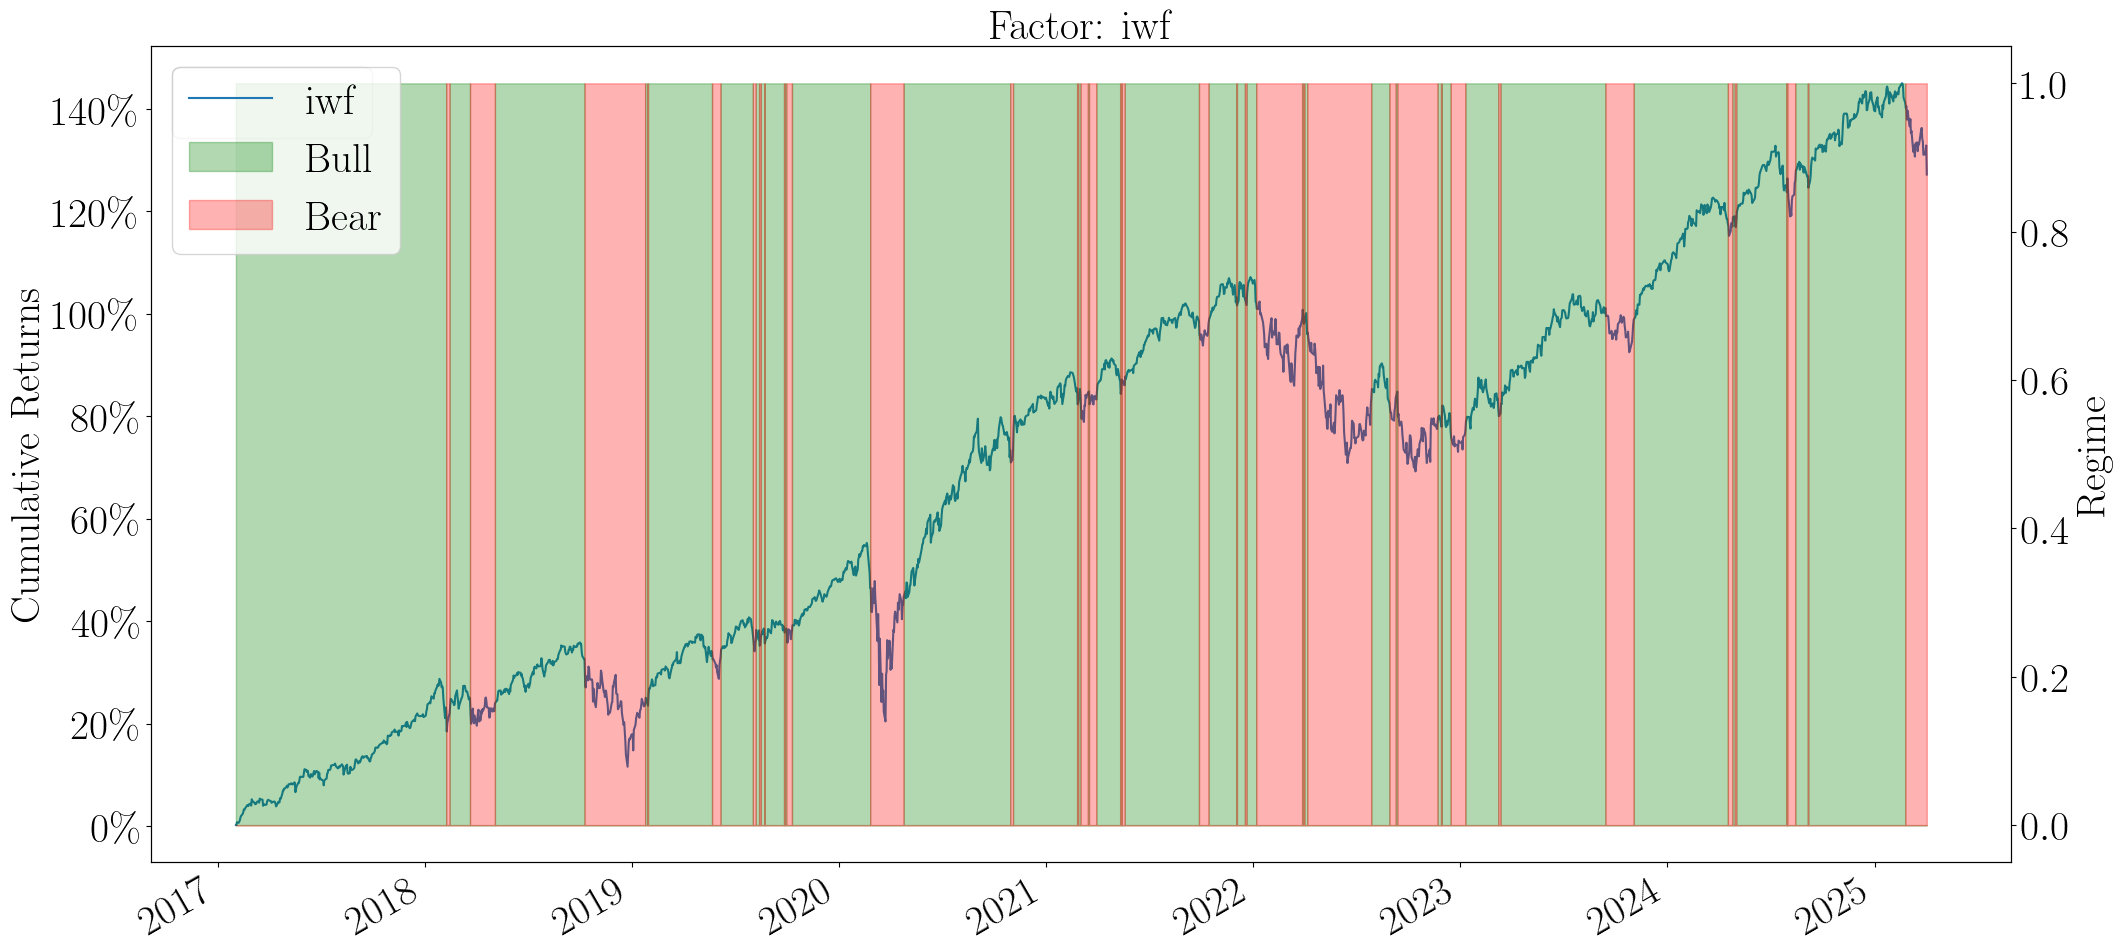

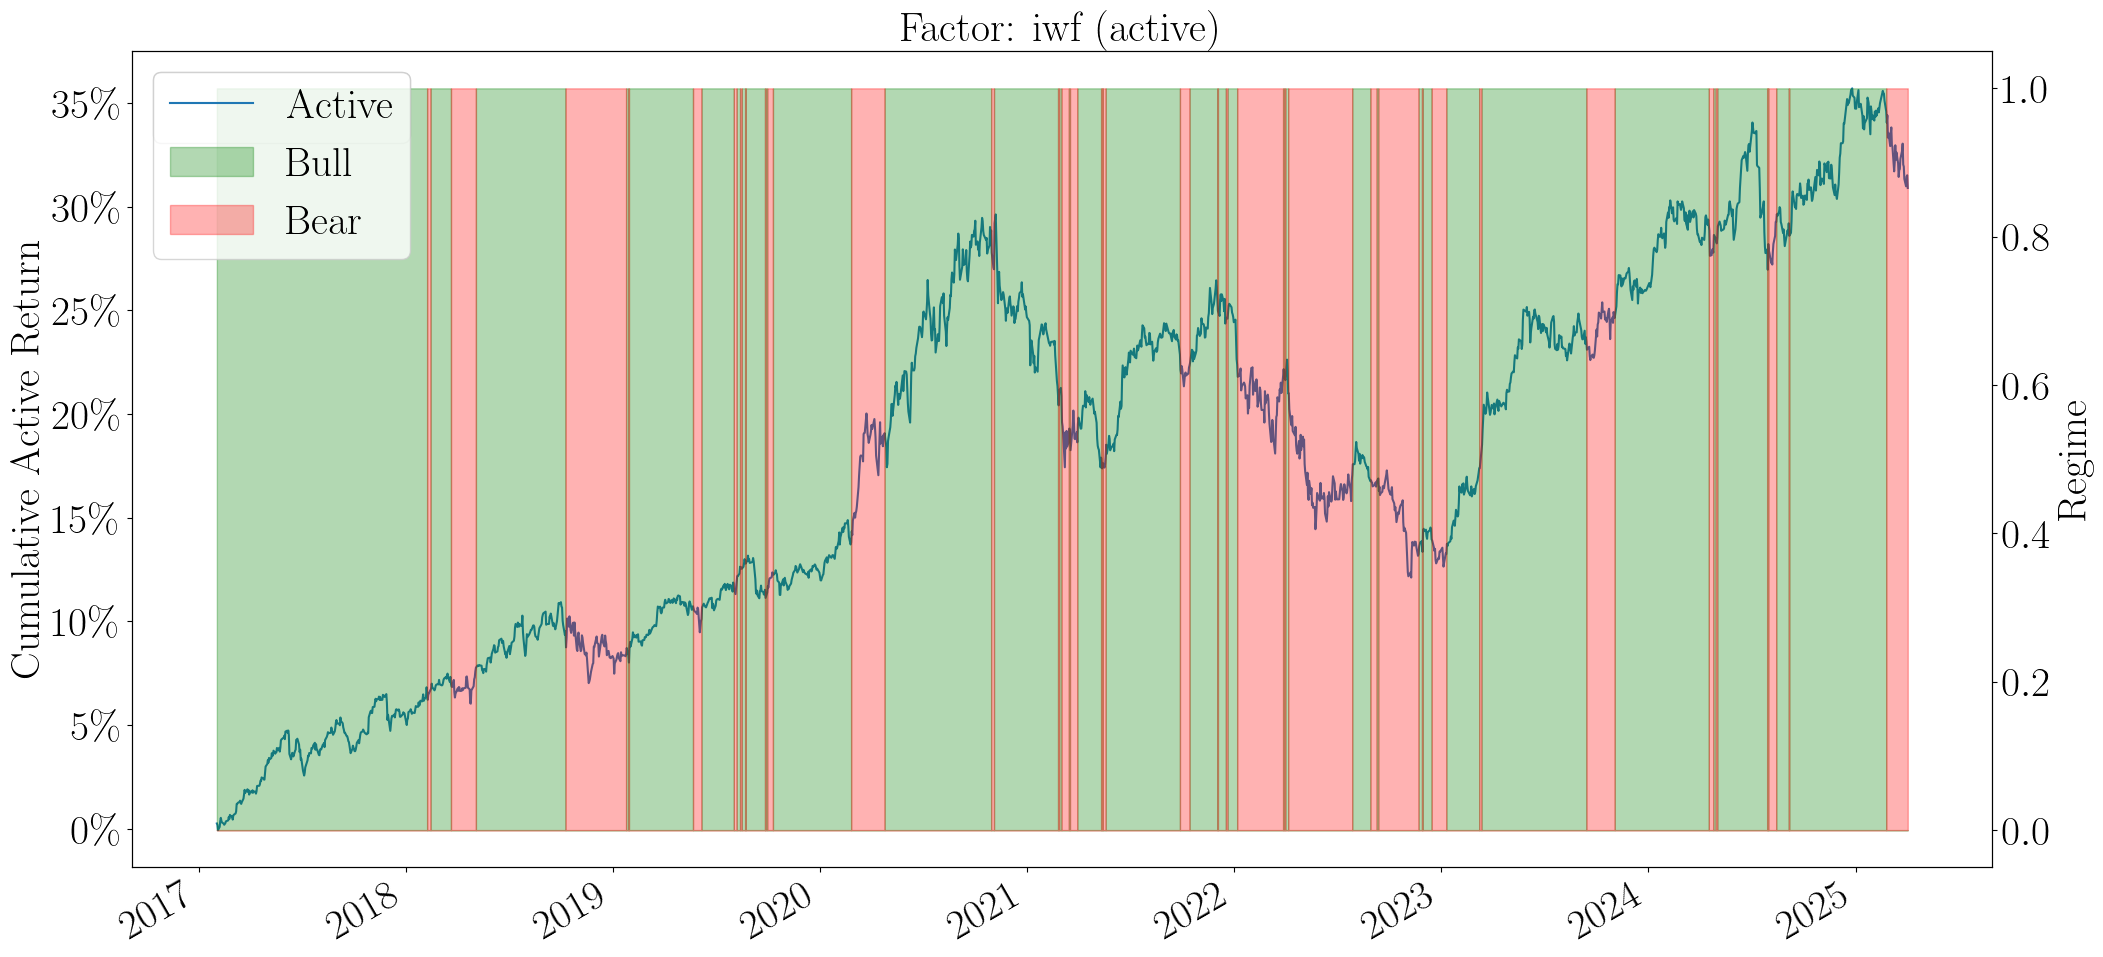

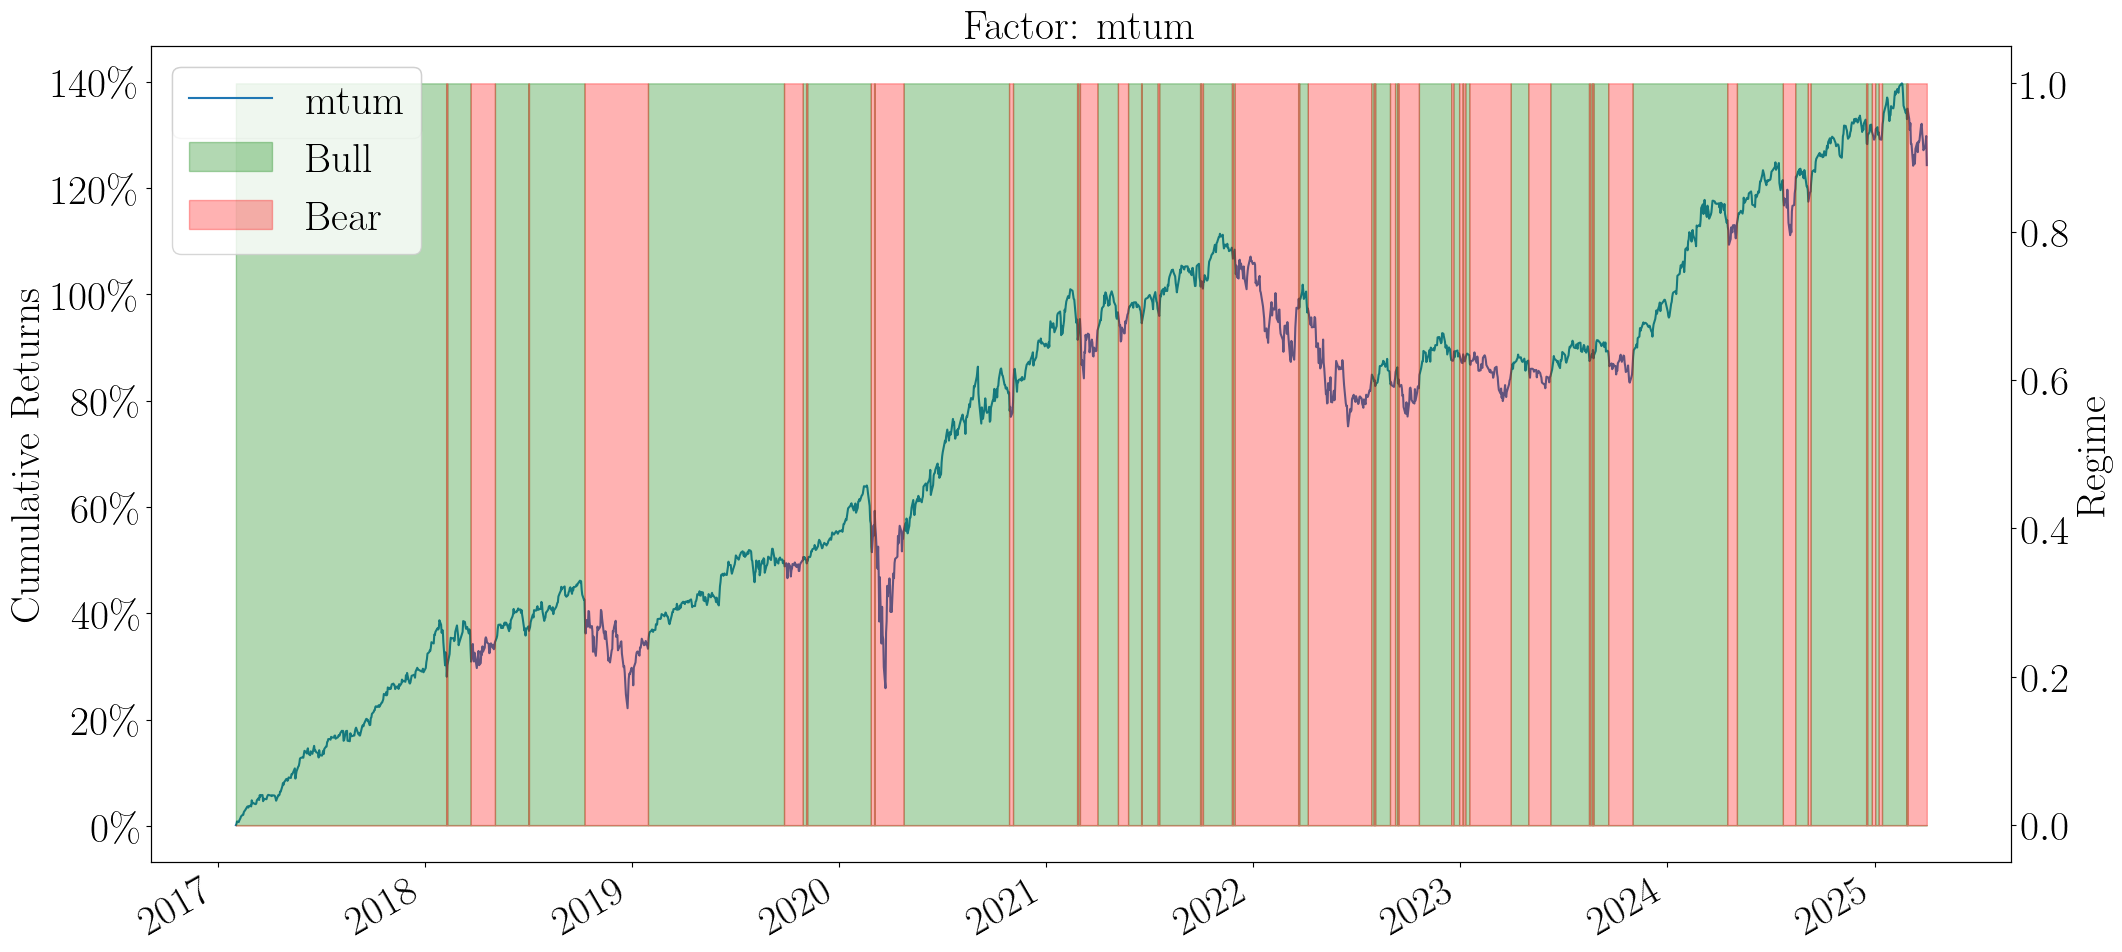

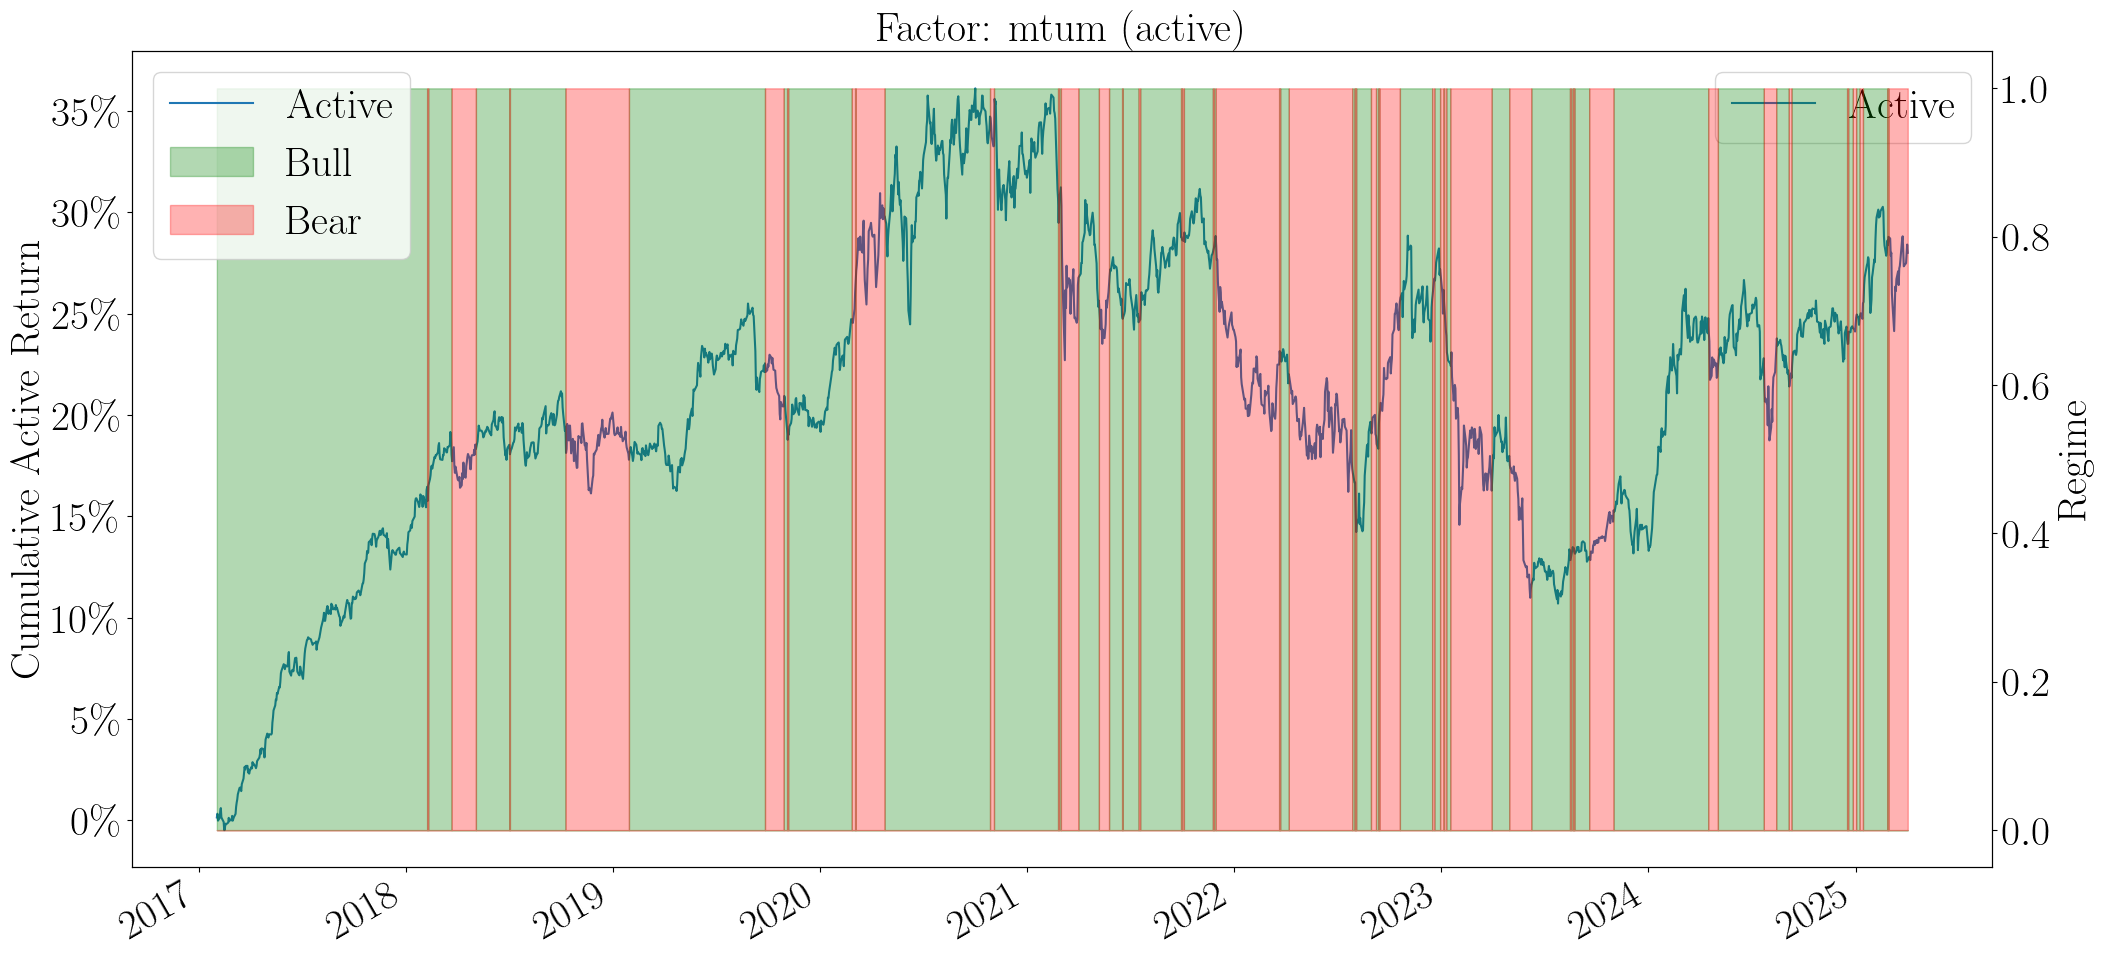

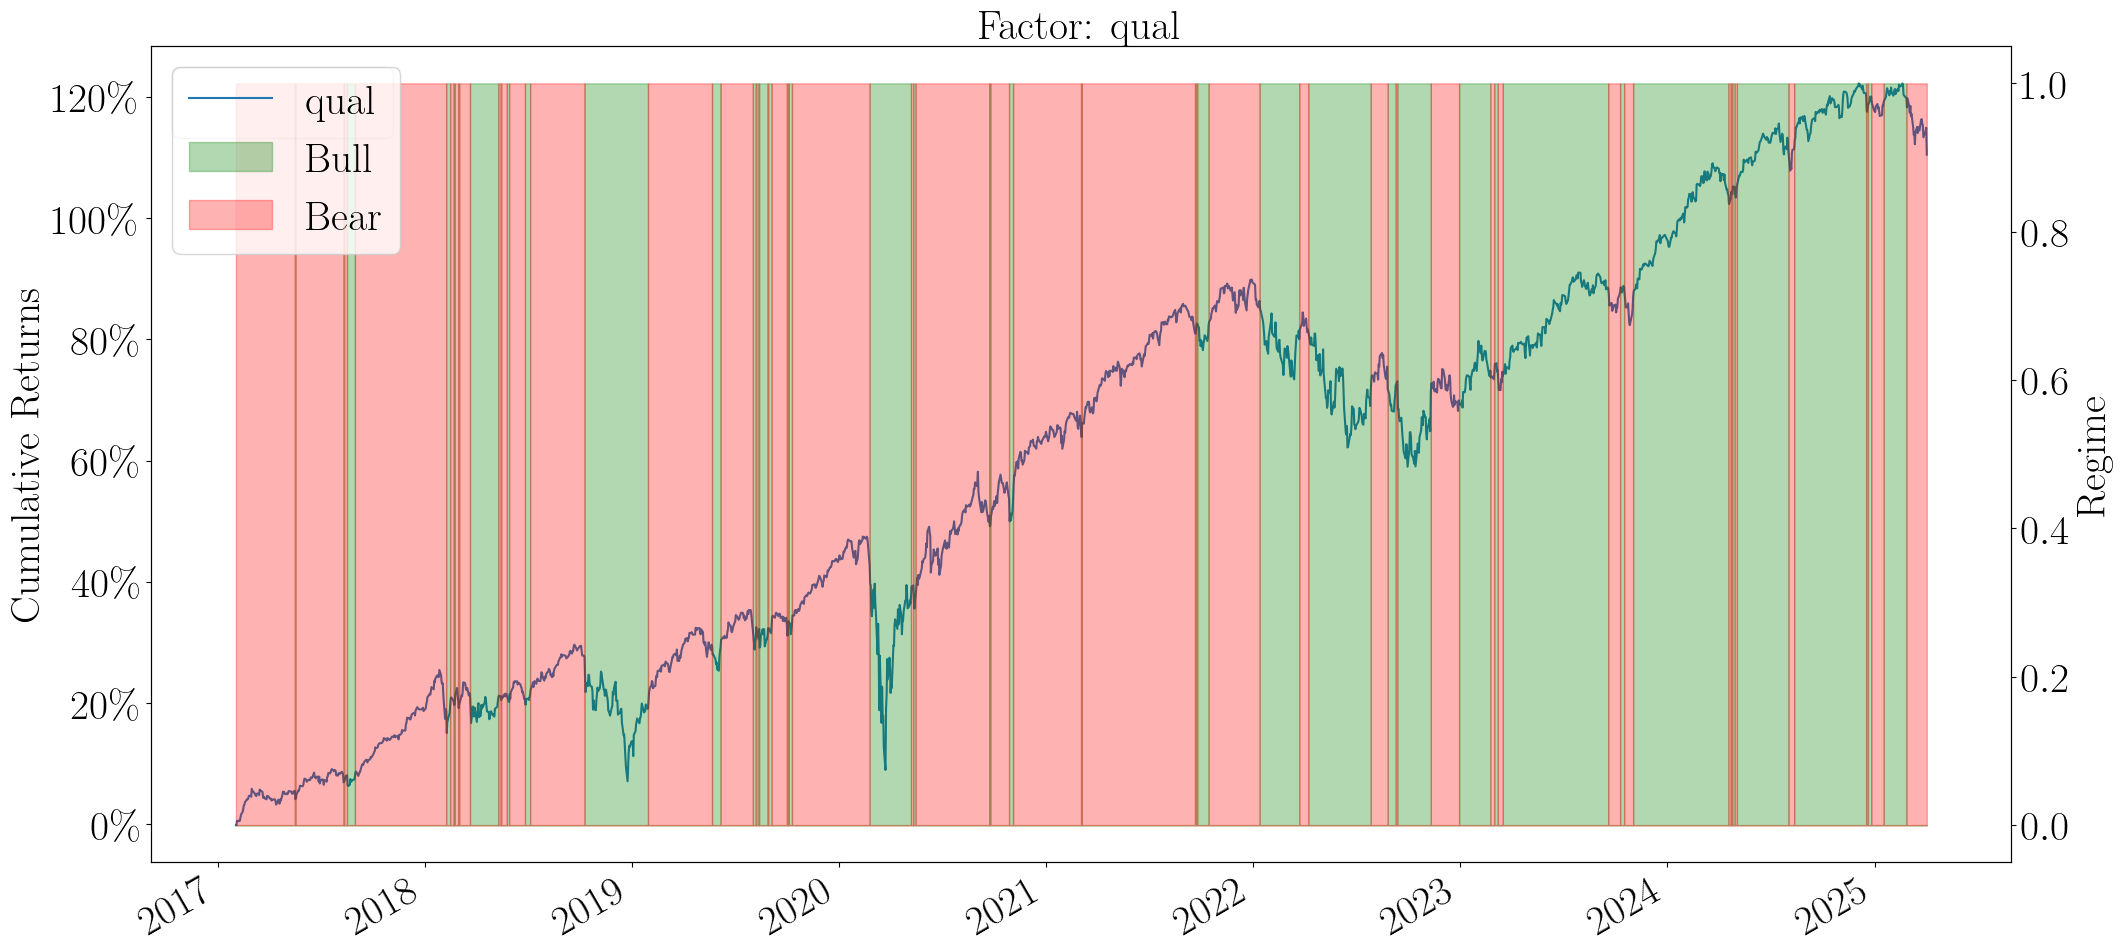

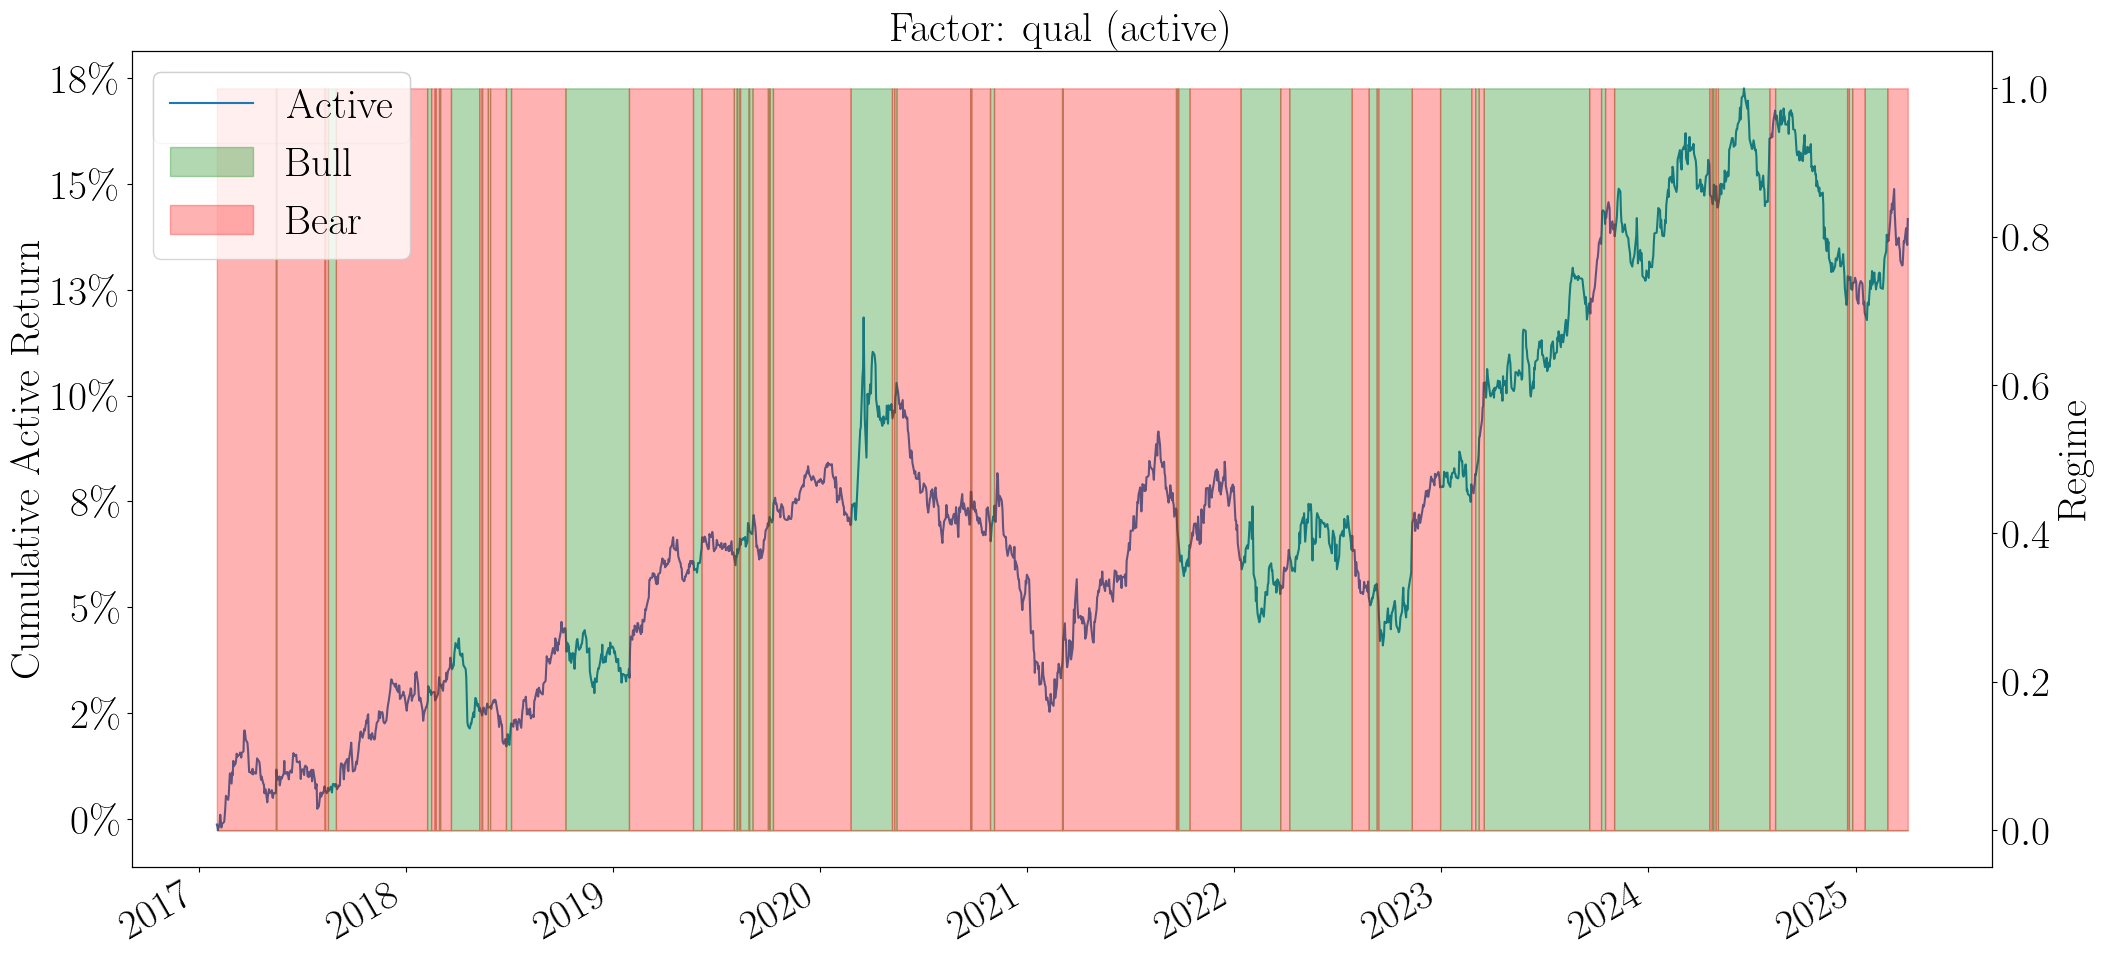

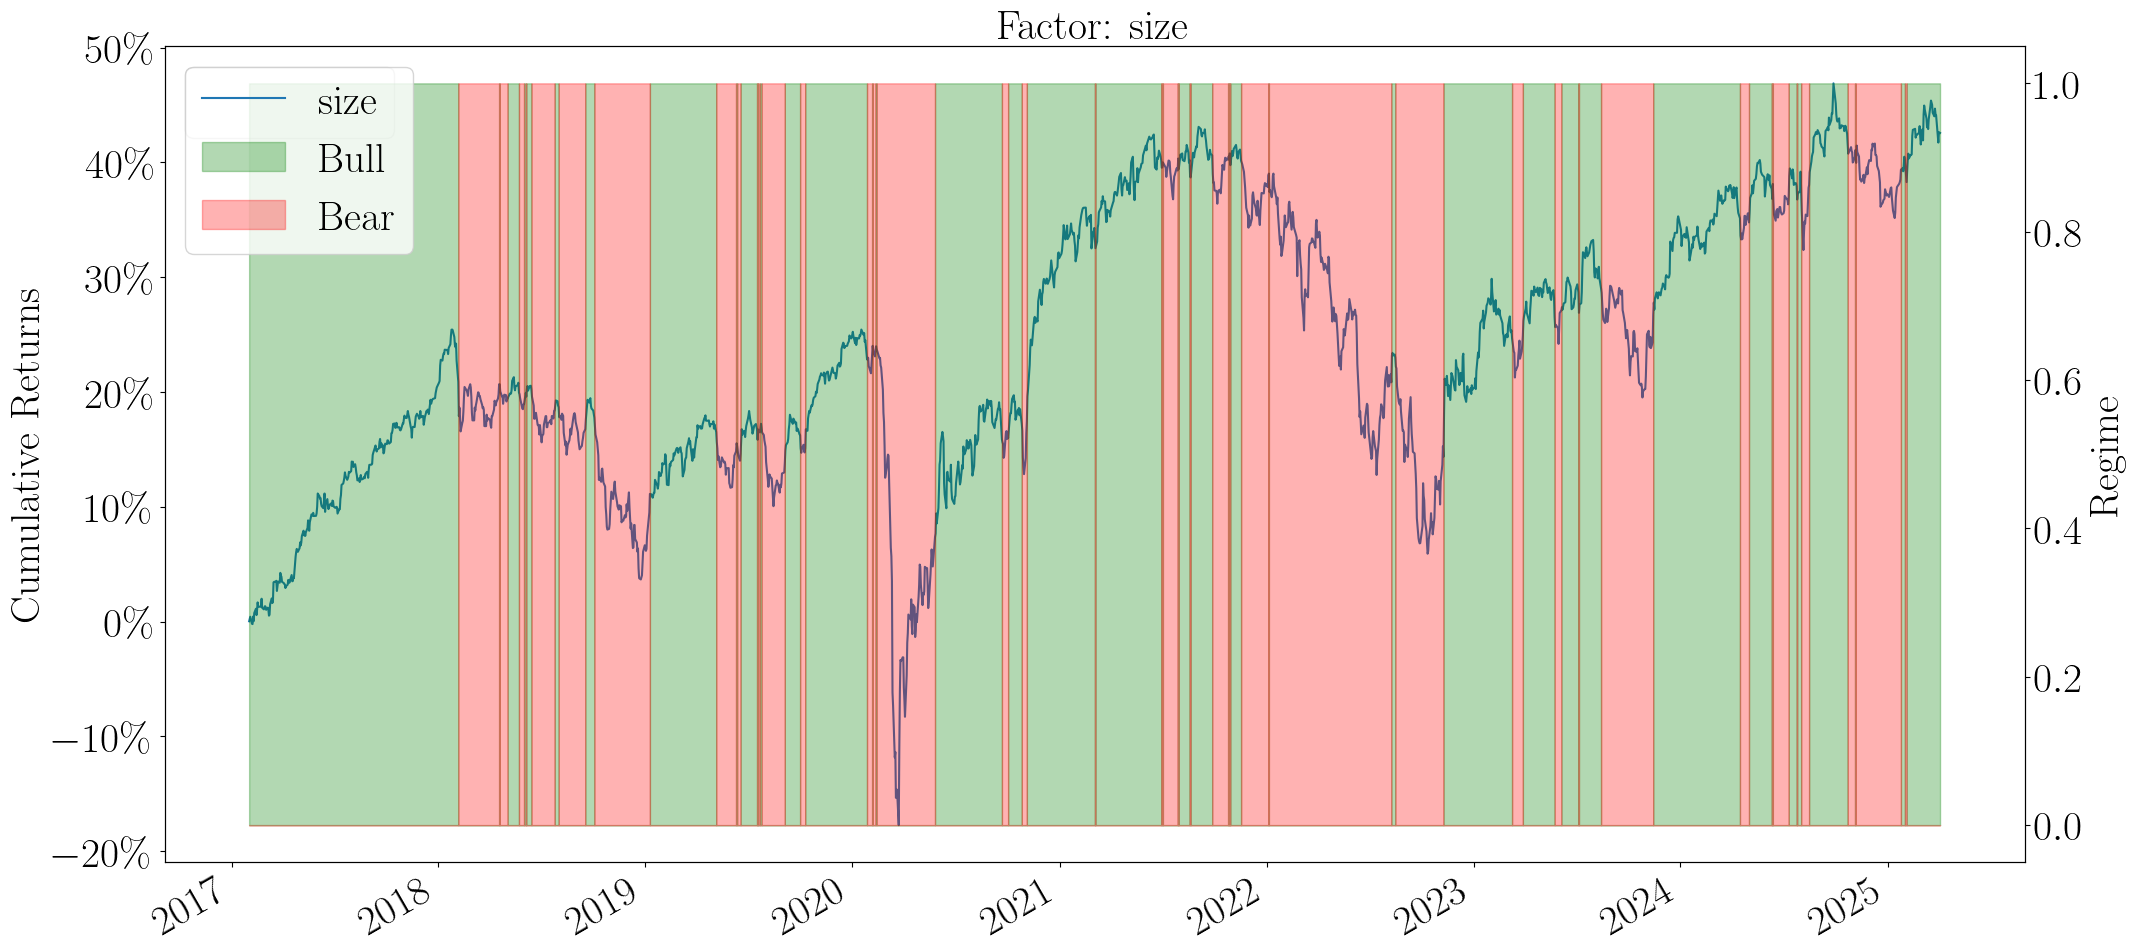

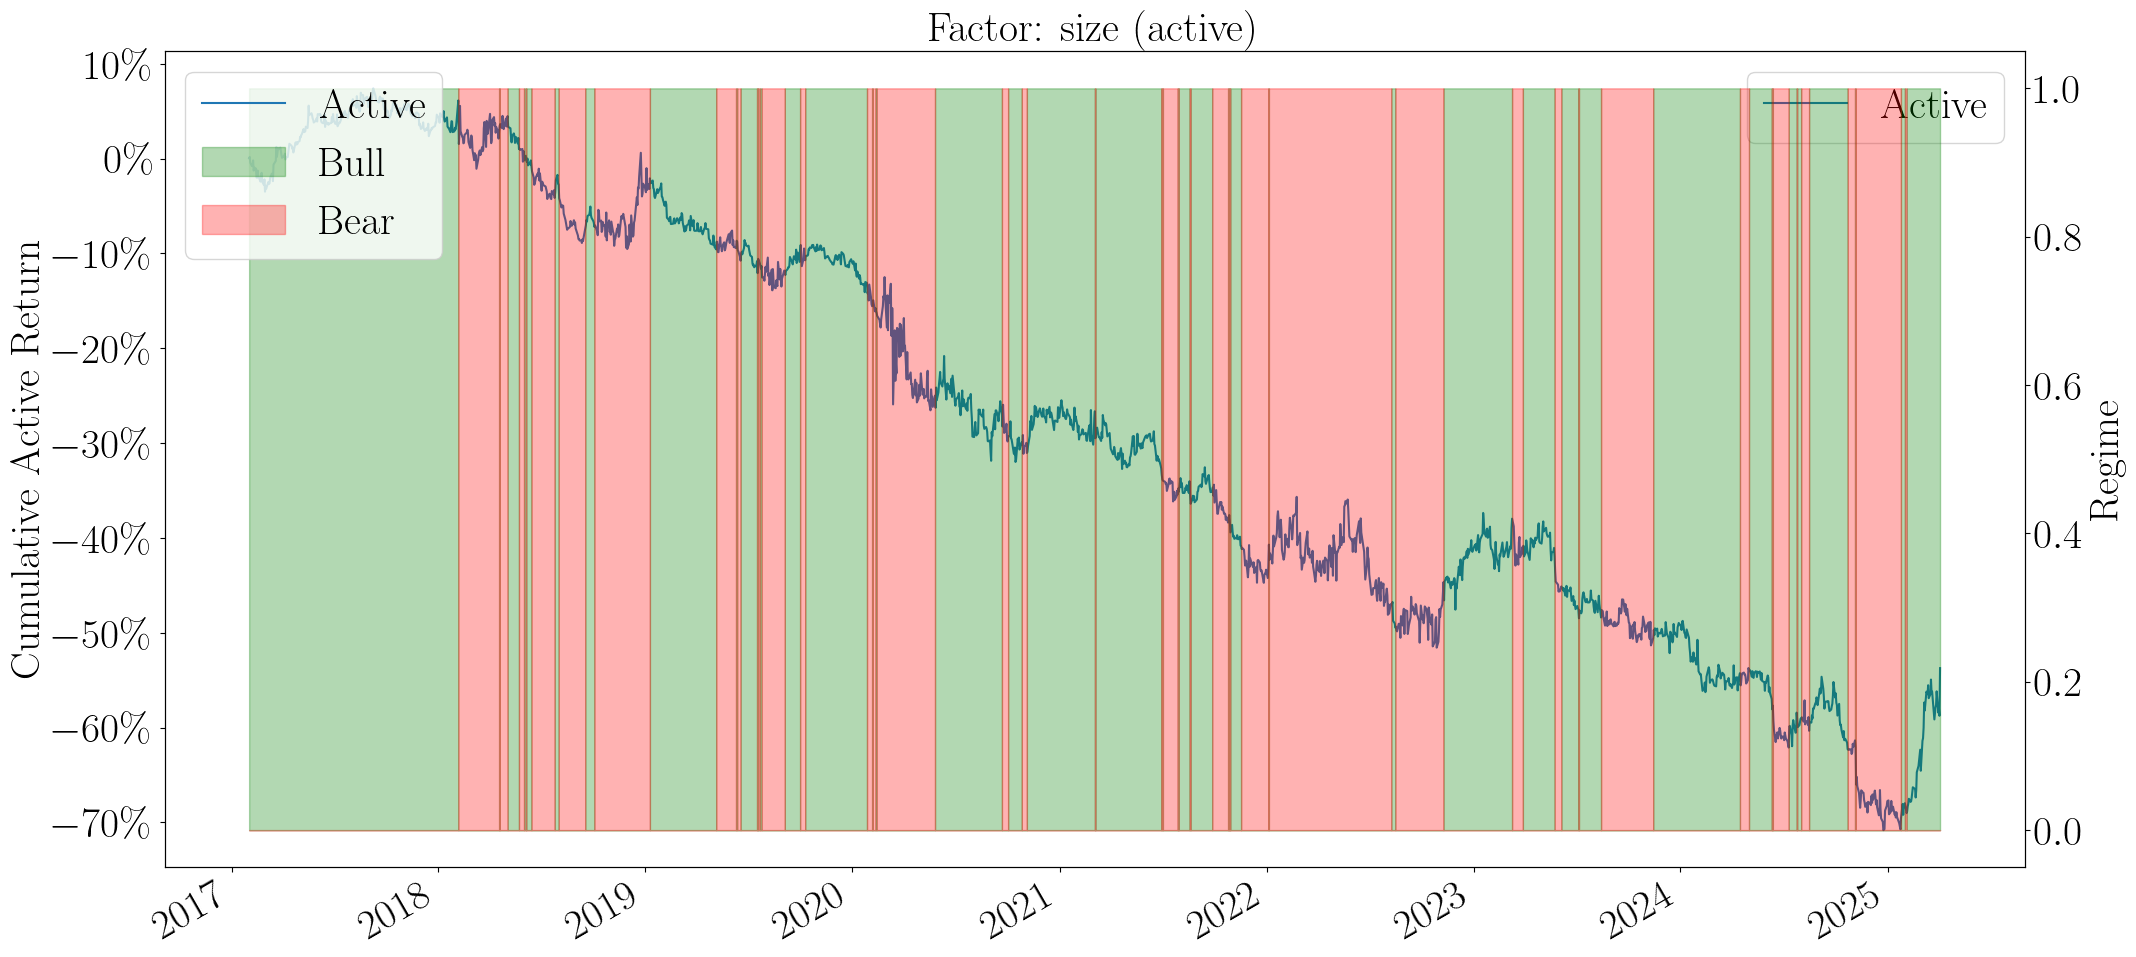

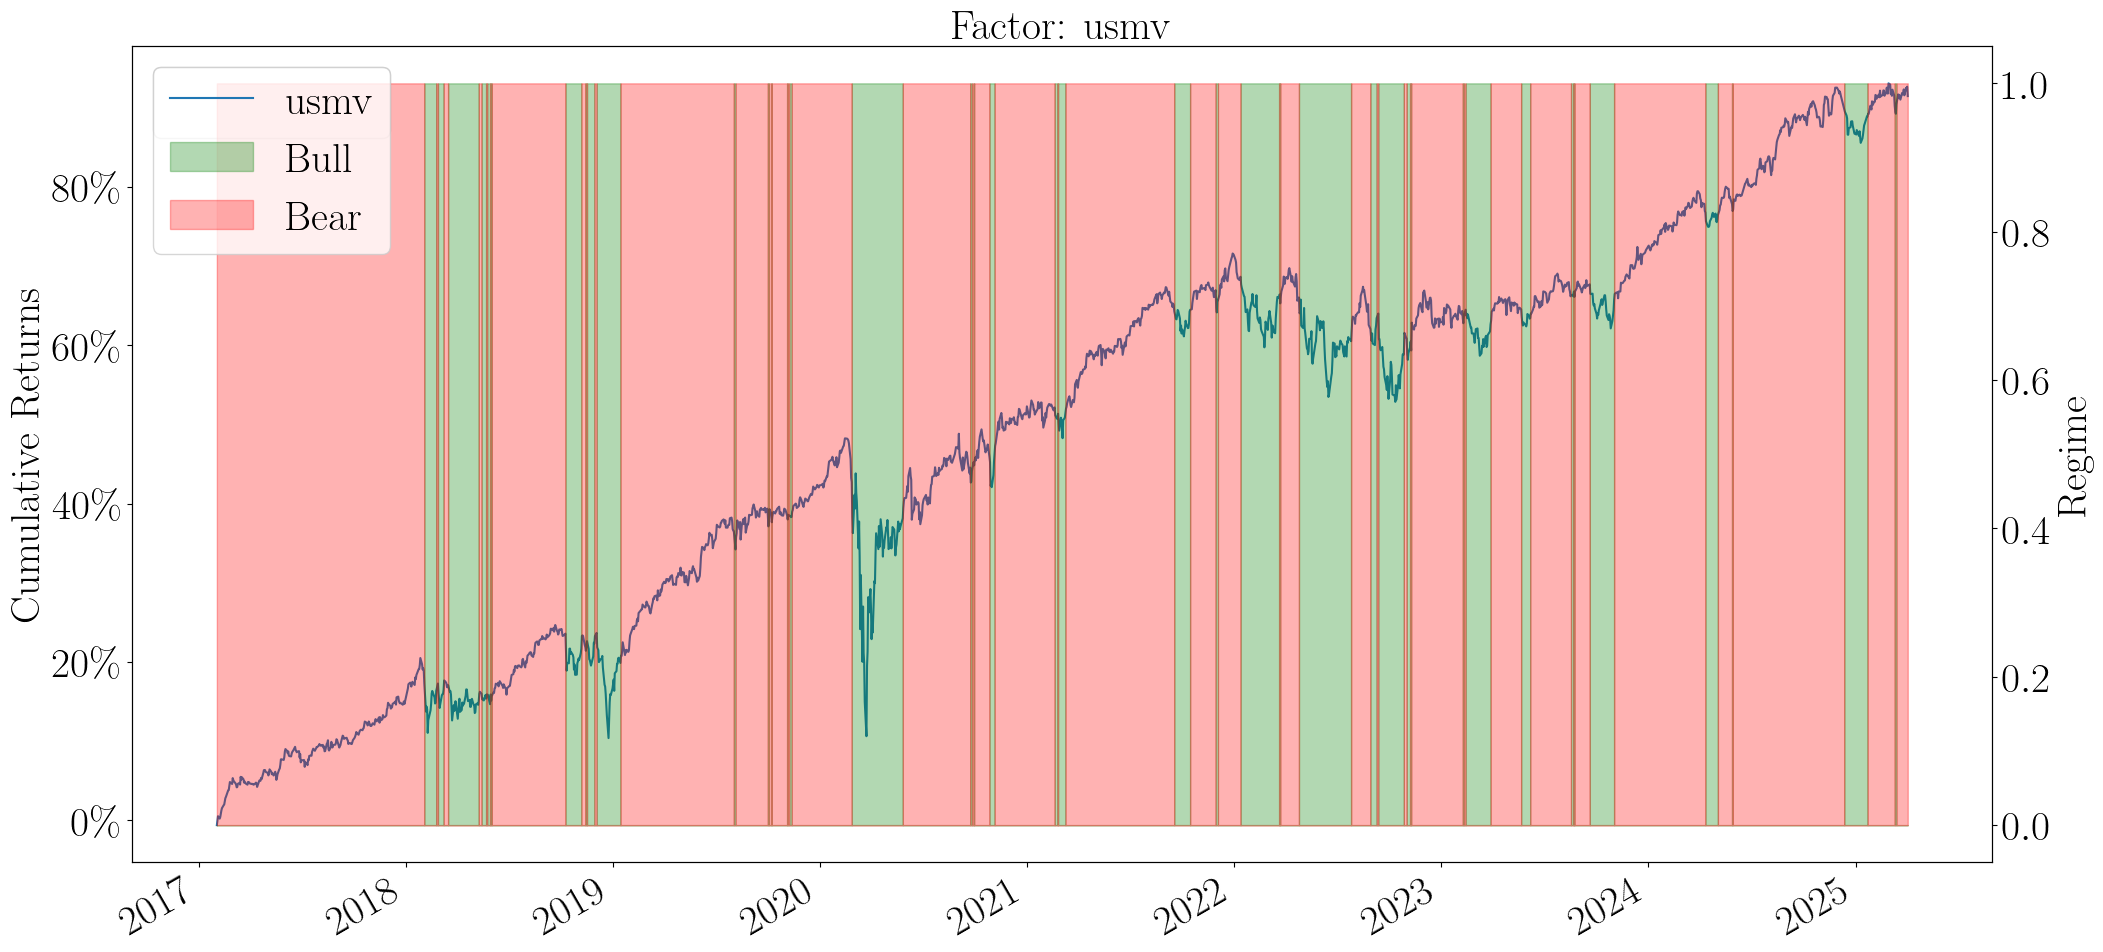

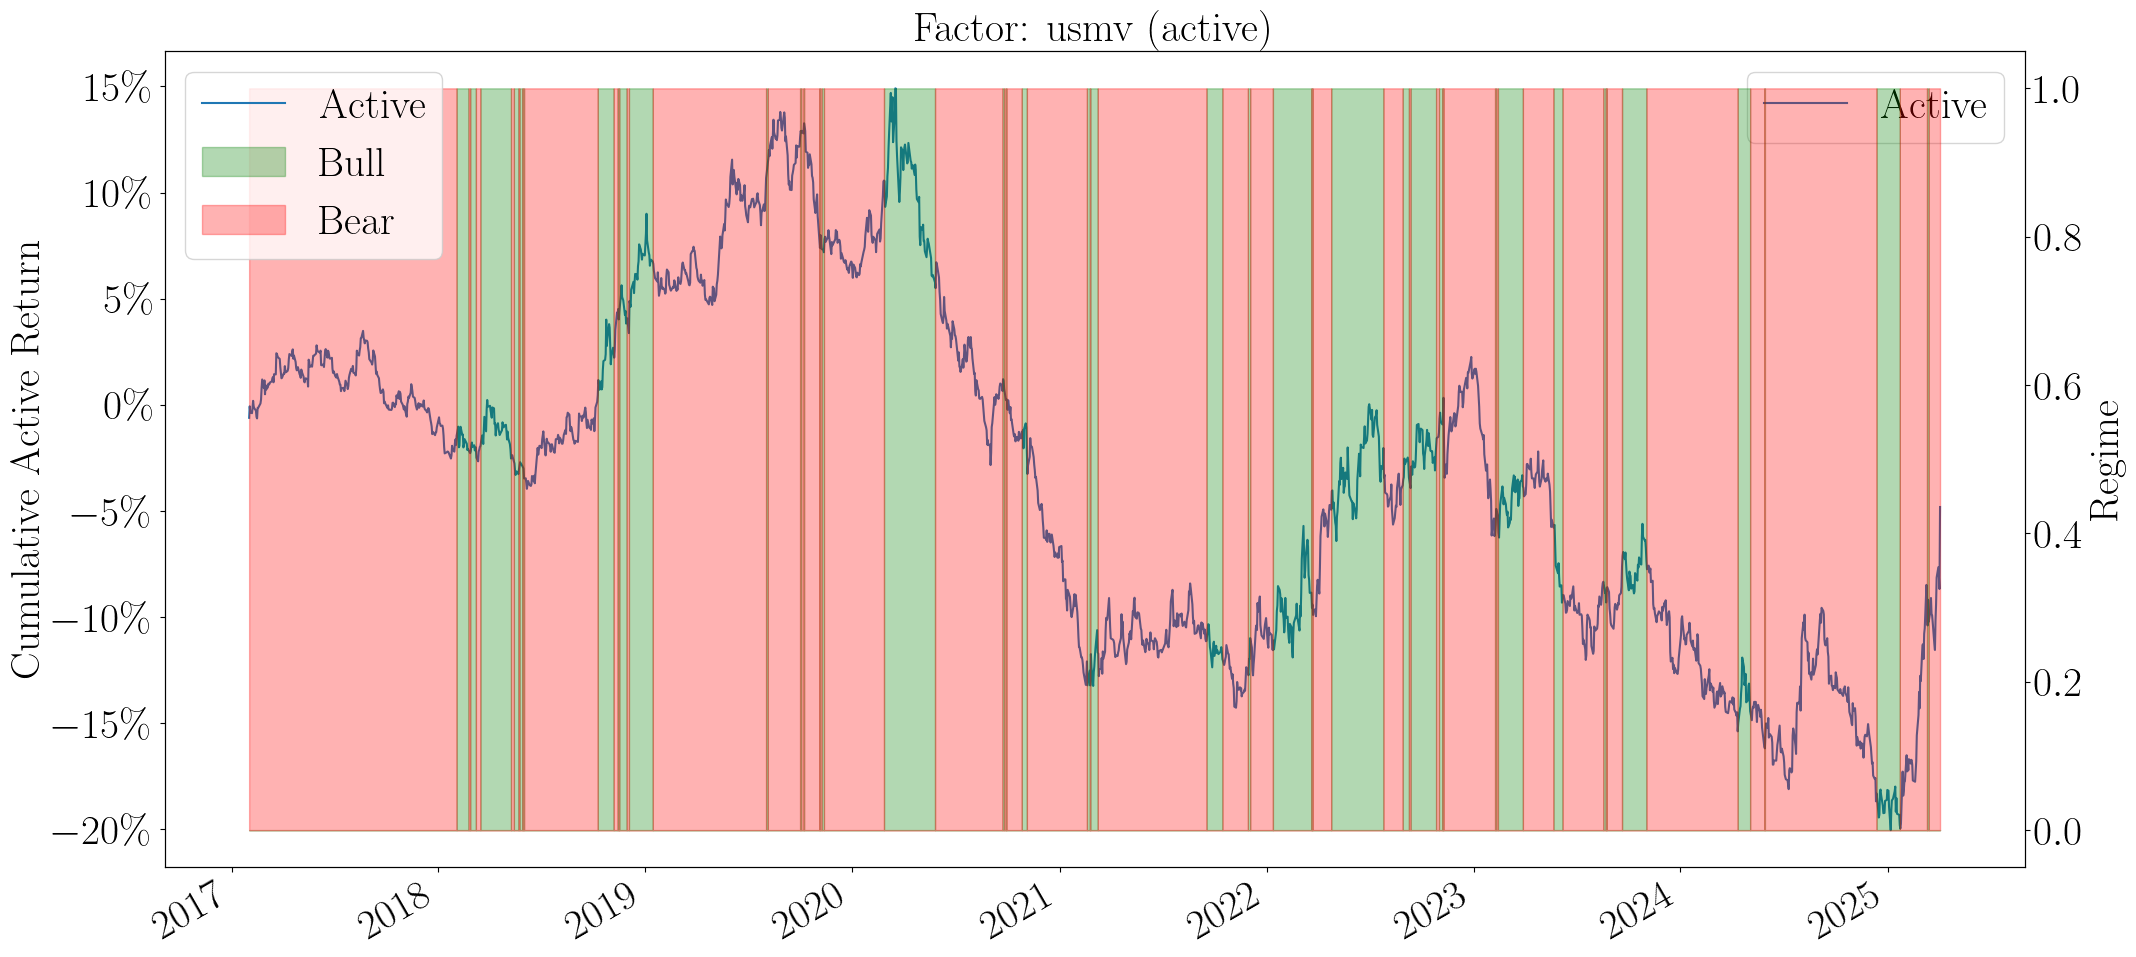

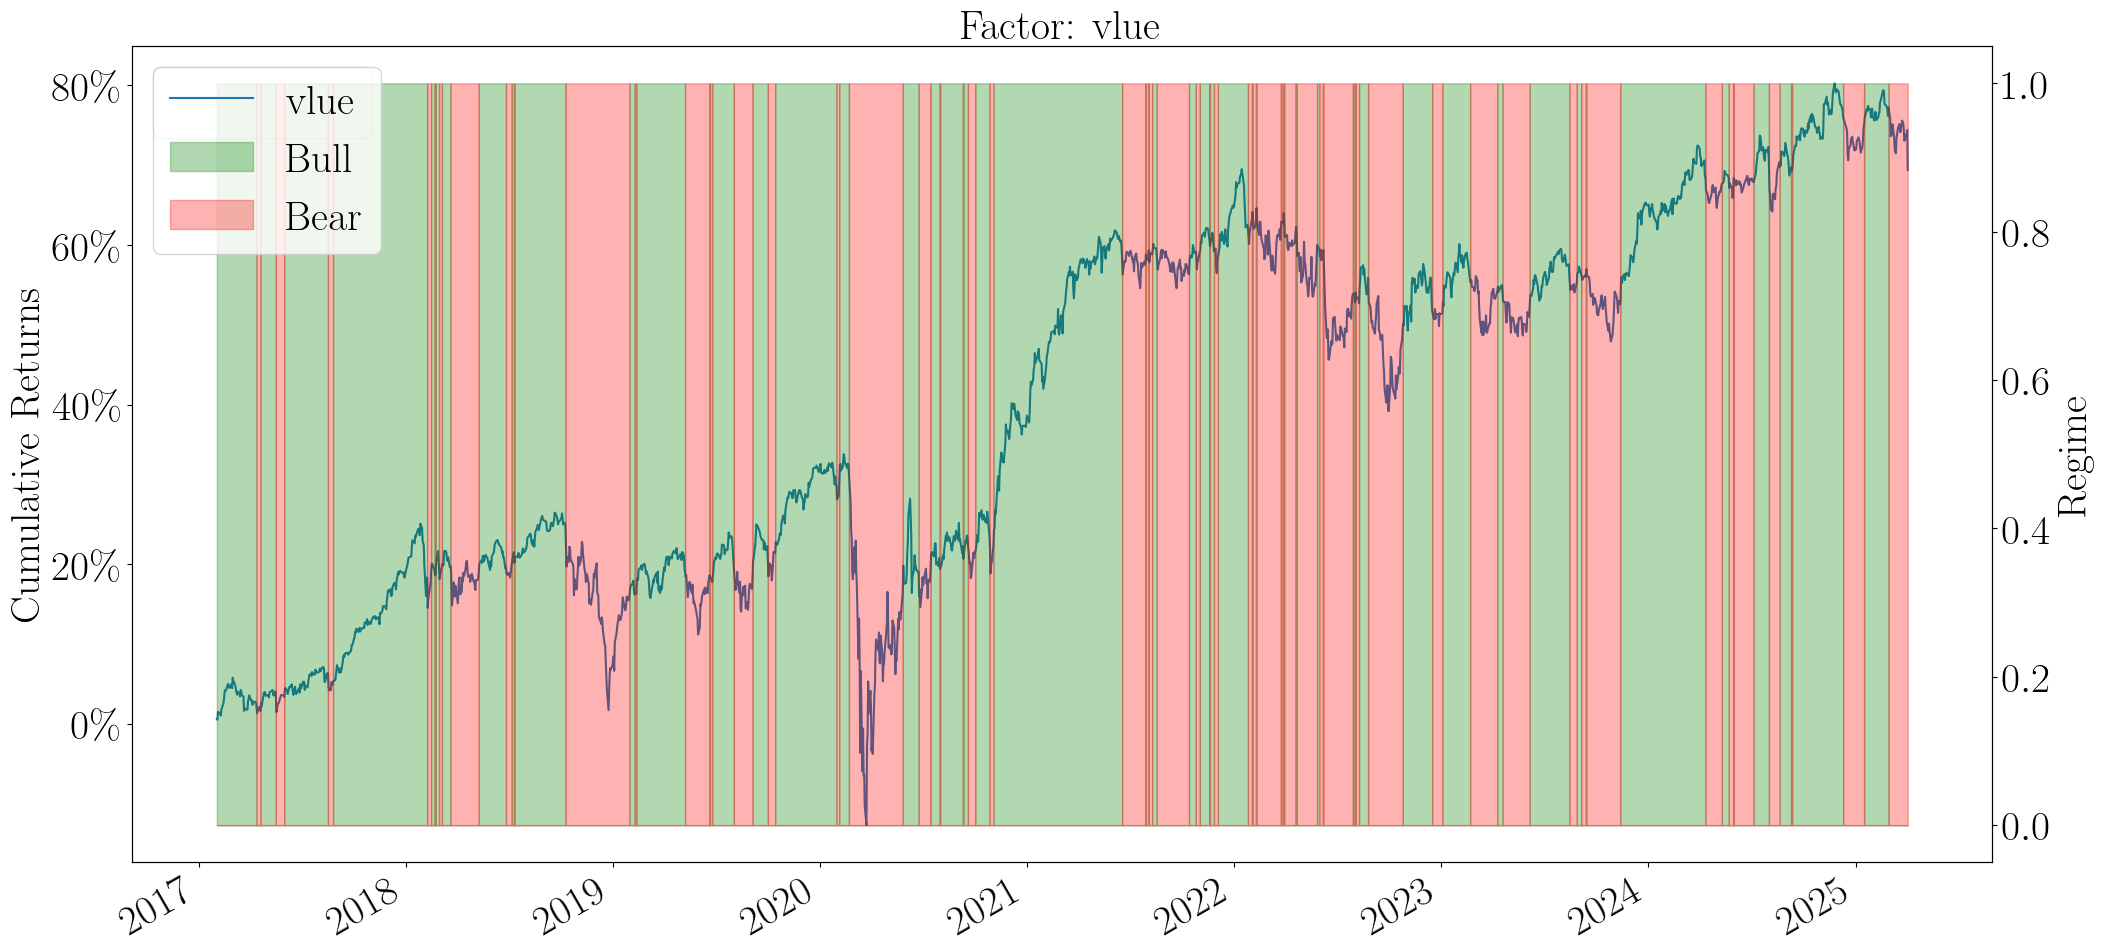

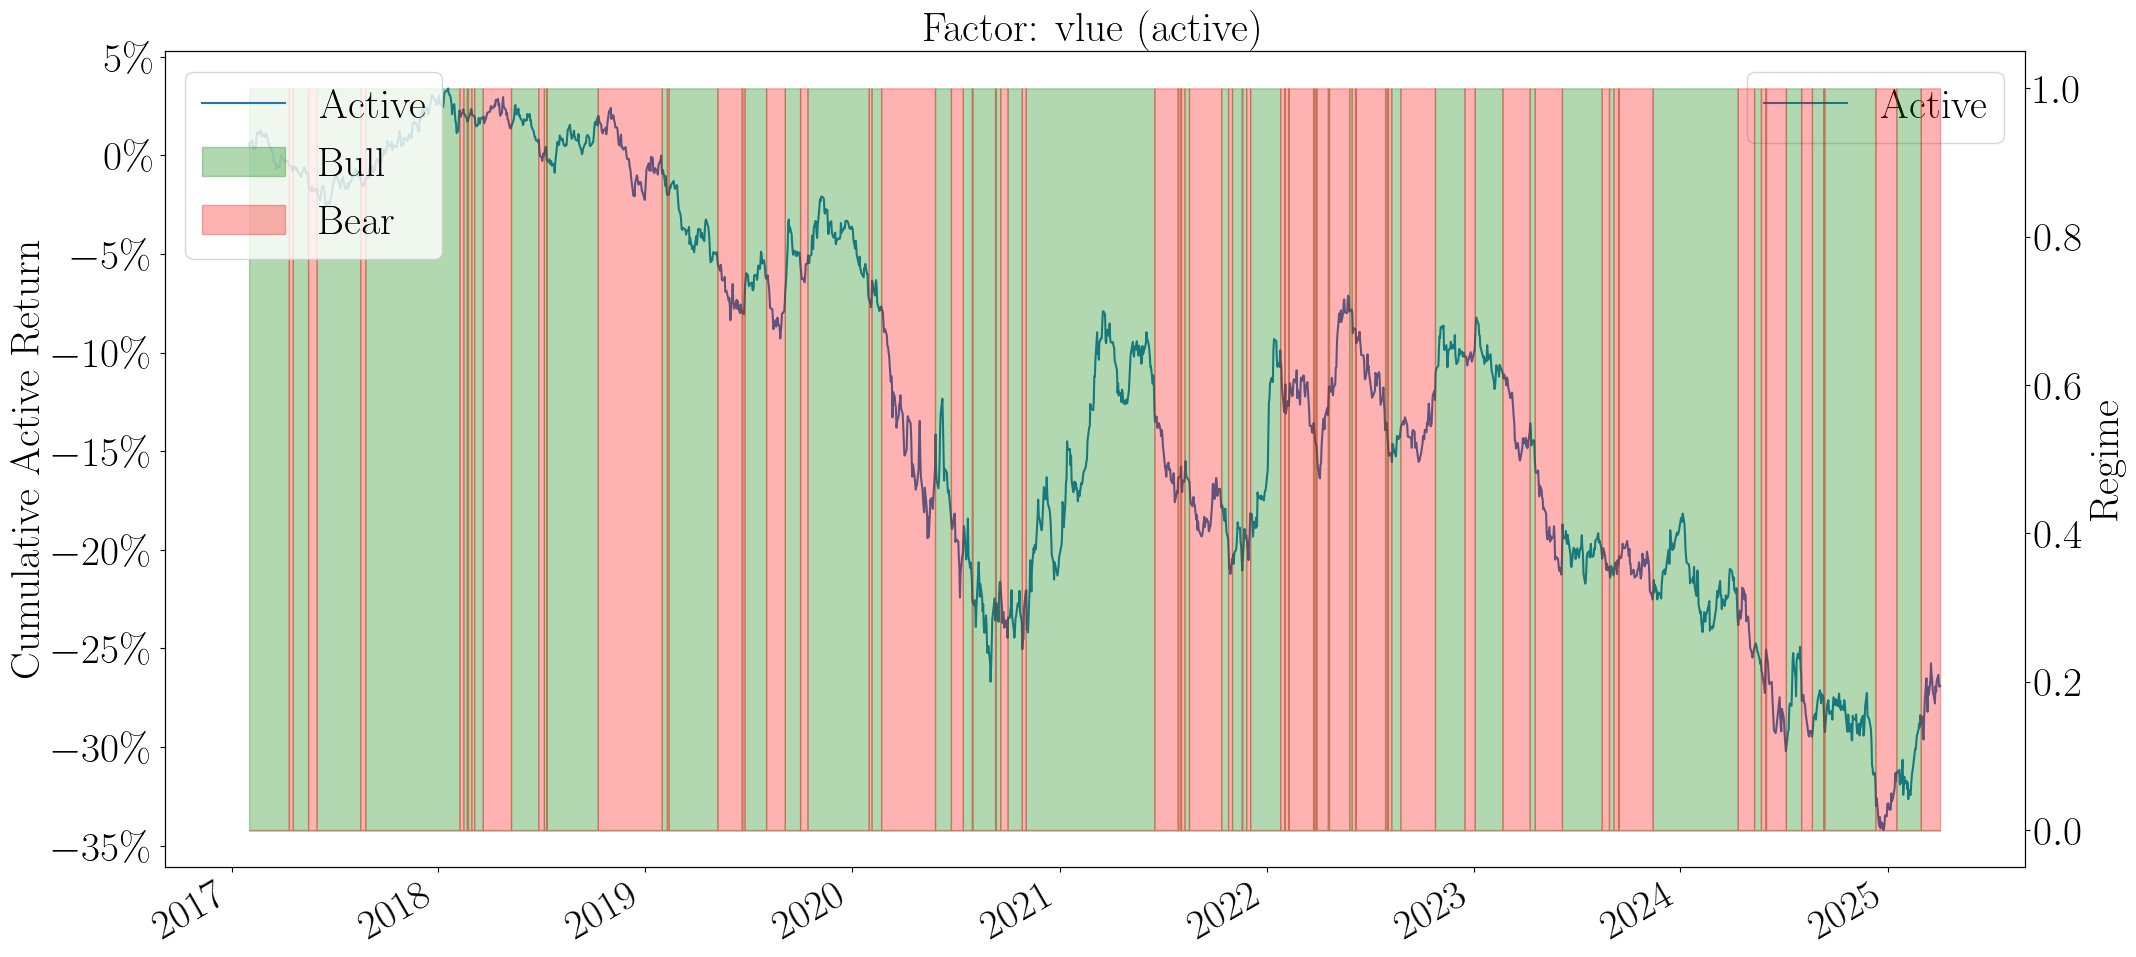

In [13]:
import matplotlib.pyplot as plt
from jumpmodels.plot import plot_regimes_and_cumret

for fac in factors:
    regimes     = factor_views[fac]["state"].dropna().astype(int)
    ret_raw     = factor_data_dict[fac]["fac_ret"].dropna()
    ret_active  = factor_data_dict[fac]["active_ret"].dropna()

    idx_raw    = regimes.index.intersection(ret_raw.index)
    idx_active = regimes.index.intersection(ret_active.index)

    # ---------- raw factor return ----------
    ax_raw, _ = plot_regimes_and_cumret(
        regimes.loc[idx_raw],
        ret_raw.loc[idx_raw],
        n_c=2,
        colors_regimes=['g','r'],
        labels_regimes=['Bull','Bear'],
        legend_loc='upper left'
    )
    ax_raw.set_title(f"Factor: {fac}")
    plt.show()

    # ---------- active return ----------
    ax_act, _ = plot_regimes_and_cumret(
        regimes.loc[idx_active],
        ret_active.loc[idx_active].to_frame("Active"),
        n_c=2,
        colors_regimes=['g','r'],
        labels_regimes=['Bull','Bear'],
        ylabel_ret="Cumulative Active Return",
        legend_loc='upper left'
    )
    ax_act.set_title(f"Factor: {fac} (active)")
    plt.show()

    
